In [1]:
import awkward
import xgboost as xgboost
import numpy as np
import os
import json
import awkward as ak
import coffea.util as util
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score

import hist

In [2]:
xgboost.__version__

'2.0.3'

# Helping functions to calculate importance and features map

In [3]:
from operator import itemgetter

def get_importance(gbm, features):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

def choose_jet(jets_variable, n, fill_value):
    """
    this helper function is used to create flat jets from a jagged collection,
    parameters:
    * jet_variable: (ak array) selected variable from the jet collection
    * n: (int) nth jet to be selected
    * fill_value: (float) value with wich to fill the padded none.
    """
    leading_jets_variable = jets_variable[
        ak.local_index(jets_variable) == n
    ]
    leading_jets_variable = ak.pad_none(
        leading_jets_variable, 1
    )
    leading_jets_variable = ak.flatten(
        ak.fill_none(leading_jets_variable, fill_value)
    )
    return leading_jets_variable

# Datasets
Here we load the dataset used for the training, these are HiggsDNA Ntuples with the Diphoton preselection + 1 jet preselection applied.

In [4]:
proc_dict = {
    "ggh_M125_2017": {
        # "file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master/SYST/higgs-dna-tiziano-bevilacqua/output/output_test_dlenSig/merged/ggh_M125_2017/NOTAG_merged.parquet",
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_signal_2017_newBDT/merged_NOTAG/ggh_M125_2017/NOTAG_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": 1,
    },
    "tth_M125_2017": {
        # "file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master/SYST/higgs-dna-tiziano-bevilacqua/output/output_test_dlenSig/merged/tth_M125_2017/NOTAG_merged.parquet",
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_signal_2017_newBDT/merged_NOTAG/tth_M125_2017/NOTAG_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": 2,
    },
    "vbf_M125_2017": {
        # "file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master/SYST/higgs-dna-tiziano-bevilacqua/output/output_test_dlenSig/merged/vbf_M125_2017/NOTAG_merged.parquet",
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_signal_2017_newBDT/merged_NOTAG/vbf_M125_2017/NOTAG_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": 3,
    },
    "vh_M125_2017": {
        # "file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master/SYST/higgs-dna-tiziano-bevilacqua/output/output_test_dlenSig/merged/vh_M125_2017/NOTAG_merged.parquet",
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_signal_2017_newBDT/merged_NOTAG/vh_M125_2017/NOTAG_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": 4,
    },
    "cH_4FS_FXFX_M125_2017": {
        # "file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master/SYST/higgs-dna-tiziano-bevilacqua/output/output_test_dlenSig/merged/cH_4FS_FXFX_M125_2017/NOTAG_merged.parquet",
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_signal_2017_newBDT/merged_NOTAG/cH_4FS_FXFX_M125_2017/NOTAG_merged.parquet",
        "type": "signal",
        "label": 1.,
        "proc_id": 5,
    },
    # "bH_5FS_FXFX_M125_2017": {
    #     "file": "/work/bevila_t/HpC_Analysis/cHvsggH_BDT_training/inputs/merged/bH_5FS_FXFX_M125_2017/nominal/NOTAG_merged.parquet",
    #     "type": "background",
    #     "label": 0.,
    #     "proc_id": 6,
    # }
}

# List of fields

In [5]:
e = ak.from_parquet("/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_signal_2017_newBDT/merged_NOTAG/ggh_M125_2017/NOTAG_merged.parquet")
e.fields

['weight_central',
 'centralObjectWeight',
 'bdt_score',
 'dZ',
 'CMS_hgg_mass',
 'event',
 'pt',
 'eta',
 'phi',
 'LeadPhoton_pt_mgg',
 'LeadPhoton_eta',
 'LeadPhoton_ScEta',
 'LeadPhoton_phi',
 'LeadPhoton_mvaID',
 'SubleadPhoton_pt_mgg',
 'SubleadPhoton_eta',
 'SubleadPhoton_ScEta',
 'SubleadPhoton_phi',
 'SubleadPhoton_mvaID',
 'LeadPhoton_pt',
 'SubleadPhoton_pt',
 'LeadPhoton_energy',
 'LeadPhoton_energyErr',
 'LeadPhoton_energyRaw',
 'SubleadPhoton_energy',
 'SubleadPhoton_energyErr',
 'SubleadPhoton_energyRaw',
 'LeadPhoton_pfChargedIsoPFPV',
 'SubleadPhoton_pfChargedIsoPFPV',
 'LeadPhoton_pfChargedIsoWorstVtx',
 'SubleadPhoton_pfChargedIsoWorstVtx',
 'LeadPhoton_pfPhoIso03',
 'SubleadPhoton_pfPhoIso03',
 'Diphoton_cos_dPhi',
 'sigmaMrv',
 'sigmaMwv',
 'PV_score',
 'nPV',
 'nPU',
 'rho',
 'n_jets',
 'first_jet_pt',
 'first_jet_eta',
 'first_jet_phi',
 'first_jet_mass',
 'first_jet_hFlav',
 'first_jet_DeepFlavour_CvsL',
 'first_jet_DeepFlavour_CvsB',
 'first_jet_particleNetAK4_C

# concatenate the MC and Data events (separately) and add normalisation

In [6]:
with open(
        "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/dev-master2/higgs-dna-tiziano-bevilacqua/higgs_dna/metaconditions/cross_sections.json", "r"
    ) as pf:
        XSs = json.load(pf)

In [7]:
sig_events = []
bkg_events = []
data_events = []

# Here we select the fields, columns will be a list of key to access interesting fields (now we select all but this is not strictly necessary)
# to improve performance we can restrict to the input variables of the training
columns = [f for f in e.fields]
               
for i, dataset in enumerate(proc_dict):
    if "Data" not in dataset:
        # the branch "weight" is normalised to efficiency x acceptance, 
        # norm is a normalisation factor to get the expected event yields for a given year.
        norm = XSs[dataset]["xs"] * XSs[dataset]["bf"] * XSs["lumi"]["2017"] * 1000
        print(f"{dataset}: xsec = {XSs[dataset]['xs']}, bf = {XSs[dataset]['bf']}, lumi = {XSs['lumi']['2017']}, norm = {norm}")
    else:
        print(f"{dataset}")
    if proc_dict[dataset]["type"] == "signal":
        proc_dict[dataset]["norm"] = norm
        # the first time (for the first process) we create the array, then we concate the subsequent ones.
        # We proc_id will be used as truth value in the training.
        if len(sig_events) == 0:
            sig_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            sig_events["weight"] = sig_events["weight"] * norm
            sig_events["proc_id"] = ak.ones_like(sig_events["weight"]) * proc_dict[dataset]["proc_id"]
        else:
            tmp_ = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            tmp_["weight"] = tmp_["weight"] * norm
            tmp_["proc_id"] = ak.ones_like(tmp_["weight"]) * proc_dict[dataset]["proc_id"]
            sig_events = ak.concatenate([sig_events, tmp_])
        print(f'|----> sum normalised weights: {ak.sum(sig_events[sig_events["proc_id"] == proc_dict[dataset]["proc_id"]].weight)}')
        print(f'|----> number of events: {len(sig_events[sig_events["proc_id"] == proc_dict[dataset]["proc_id"]].weight)}')
    
    elif proc_dict[dataset]["type"] == "background":
        proc_dict[dataset]["norm"] = norm
        # Same for the background, here we also rescale the weights of a factor of 1.4, this is to get abetter data/MC agreement.
        if len(bkg_events) == 0:
            bkg_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            bkg_events["weight"] = bkg_events["weight"] * norm
            bkg_events["proc_id"] = ak.ones_like(bkg_events["weight"]) * proc_dict[dataset]["proc_id"]
        else:
            tmp_ = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            tmp_["weight"] = tmp_["weight"] * norm
            tmp_["proc_id"] = ak.ones_like(tmp_["weight"]) * proc_dict[dataset]["proc_id"]
            bkg_events = ak.concatenate([bkg_events, tmp_])
        print(f'|----> sum normalised weights: {ak.sum(bkg_events[bkg_events["proc_id"] == proc_dict[dataset]["proc_id"]].weight)}')
        print(f'|----> number of events: {len(bkg_events[bkg_events["proc_id"] == proc_dict[dataset]["proc_id"]].weight)}')
        
    elif proc_dict[dataset]["type"] == "data":
        # For Data nothing is done to the weights
        if len(data_events) == 0:
            data_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            data_events["proc_id"] = ak.ones_like(data_events["weight"]) * proc_dict[dataset]["proc_id"]
        else:
            tmp_ = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            tmp_["proc_id"] = ak.ones_like(tmp_["weight"]) * proc_dict[dataset]["proc_id"]
            data_events = ak.concatenate([data_events, tmp_])

sig_events["label"] = ak.ones_like(sig_events["weight"])
bkg_events["label"] = ak.zeros_like(bkg_events["weight"])
# data_events["label"] = ak.ones_like(data_events["weight"]) * -1. 

ggh_M125_2017: xsec = 48.58, bf = 0.00227, lumi = 41.5, norm = 4576.4789
|----> sum normalised weights: 1107.0507859017773
|----> number of events: 262972
tth_M125_2017: xsec = 0.5071, bf = 0.00227, lumi = 41.5, norm = 47.77135549999999
|----> sum normalised weights: 22.699130614874377
|----> number of events: 384537
vbf_M125_2017: xsec = 3.782, bf = 0.00227, lumi = 41.5, norm = 356.28331
|----> sum normalised weights: 124.35698809896502
|----> number of events: 1490639
vh_M125_2017: xsec = 2.2555, bf = 0.00227, lumi = 41.5, norm = 212.47937749999997
|----> sum normalised weights: 73.27163144908486
|----> number of events: 330893
cH_4FS_FXFX_M125_2017: xsec = 0.09013, bf = 0.00227, lumi = 41.5, norm = 8.490696649999999
|----> sum normalised weights: 1.9303478932234095
|----> number of events: 1281864


Here we concatenate once more to have an array containing both Signal and Background MC.

We also calculate missing variables for the training

In [8]:
MC_events = ak.concatenate([sig_events, bkg_events])

# add VtxProbability 
MC_events["vtxProb"] = 2 * MC_events["sigmaMrv"] / (MC_events["sigmaMrv"] + MC_events["sigmaMwv"])
# data_events["vtxProb"] = 2 * data_events["sigmaMrv"] / (data_events["sigmaMrv"] + data_events["sigmaMwv"])
MC_events = ak.values_astype(MC_events, np.float64)
data_events = ak.values_astype(data_events, np.float64)
# MC_events.fields

The events that don't contain some variables (i.e. a second jet in the event) are padded in HiggsDNA with -999. dummy values.

Here we change that to -1 and we create some other auxiliary variables used in the training, to remove correlations we divide by the mass.

In [9]:
MC_events["dEta_ljh"] = abs(MC_events.eta - MC_events.first_jet_eta)
MC_events["dEta_sljh"] = ak.where(
    MC_events["second_jet_eta"] != -999.,
    abs(MC_events.eta - MC_events.second_jet_eta),
    ak.ones_like(MC_events.second_jet_eta) * -1
)
MC_events["dR_ljlp"] = np.sqrt((MC_events.LeadPhoton_eta - MC_events.first_jet_eta)**2 + (MC_events.DeltaPhi_gamma1_cjet)**2)
MC_events["dR_ljslp"] = np.sqrt((MC_events.SubleadPhoton_eta - MC_events.first_jet_eta)**2 + (MC_events.DeltaPhi_gamma2_cjet)**2)

MC_events["lj_ptoM"] = MC_events.first_jet_pt / MC_events.first_jet_mass

MC_events["slj_ptoM"] =  ak.where(
    MC_events.second_jet_pt != -999,
    MC_events.second_jet_pt / MC_events.second_jet_mass,
    ak.ones_like(MC_events.second_jet_pt) * -1
)

MC_events["first_SV_ptoM"] = ak.where(
    MC_events.first_sv_pt != -999,
    MC_events.first_sv_pt/MC_events.first_sv_mass,
    ak.ones_like(MC_events.first_sv_pt) * -1
)

MC_events["first_SV_ptoH_pt"] = MC_events.first_sv_pt/MC_events.pt
MC_events["Sv_J_MoM"] = ak.where(
    MC_events.first_sv_pt != -999,
    abs(MC_events.first_sv_mass/MC_events.first_jet_mass),
    ak.ones_like(MC_events.first_sv_pt) * -1
)


/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(


We do the same here and we correct the few events in which some variables have been divided for a too small number by putting a higher limit to the value they can assume.

In [10]:
MC_events["Sv_J_MoM"] = awkward.where(
        MC_events["Sv_J_MoM"] > 50000,
        ak.ones_like(MC_events.Sv_J_MoM) * 50000,
        MC_events["Sv_J_MoM"]
)
MC_events["lj_ptoM"] = awkward.where(
        MC_events["lj_ptoM"] > 50000,
        ak.ones_like(MC_events.lj_ptoM) * 50000,
        MC_events["lj_ptoM"]
)
MC_events["slj_ptoM"] = awkward.where(
        MC_events["slj_ptoM"] > 50000,
        ak.ones_like(MC_events.slj_ptoM) * 50000,
        MC_events["slj_ptoM"]
)
MC_events["lj_ptoM"] = awkward.where(
        MC_events["lj_ptoM"] < -1.,
        ak.ones_like(MC_events.lj_ptoM) * -1,
        MC_events["lj_ptoM"]
)
MC_events["slj_ptoM"] = awkward.where(
        MC_events["slj_ptoM"] < -1.,
        ak.ones_like(MC_events.slj_ptoM) * -1,
        MC_events["slj_ptoM"]
)
MC_events["first_SV_ptoM"] = awkward.where(
        MC_events["first_sv_pt"] < -1.,
        ak.ones_like(MC_events.slj_ptoM) * -1.,
        MC_events["first_SV_ptoM"]
)
MC_events["first_sv_mass"] = awkward.where(
        MC_events["first_sv_mass"] < -1,
        ak.ones_like(MC_events.slj_ptoM) * -1.,
        MC_events["first_sv_mass"]
)
MC_events["first_sv_pt"] = awkward.where(
        MC_events["first_sv_pt"] < -1,
        ak.ones_like(MC_events.first_sv_pt) * -1.,
        MC_events["first_sv_pt"]
)
MC_events["first_jet_n_sv"] = awkward.where(
        MC_events["first_jet_n_sv"] < -10,
        ak.ones_like(MC_events.first_jet_n_sv) * -1.,
        MC_events["first_jet_n_sv"]
)
MC_events["first_jet_n_muons"] = awkward.where(
        MC_events["first_jet_n_muons"] < -10,
        ak.ones_like(MC_events.first_jet_n_muons) * -1.,
        MC_events["first_jet_n_muons"]
)
MC_events["first_jet_n_electrons"] = awkward.where(
        MC_events["first_jet_n_electrons"] < -10,
        ak.ones_like(MC_events.first_jet_n_electrons) * -1.,
        MC_events["first_jet_n_electrons"]
)
MC_events["first_SV_ptoH_pt"] = awkward.where(
        MC_events["first_SV_ptoH_pt"] > 50000,
        ak.ones_like(MC_events.slj_ptoM) * 50000,
        MC_events["first_SV_ptoH_pt"]
)
MC_events["first_SV_ptoH_pt"] = awkward.where(
        MC_events["first_SV_ptoH_pt"] < 0,
        ak.ones_like(MC_events.slj_ptoM) * -1,
        MC_events["first_SV_ptoH_pt"]
)

In [11]:
MC_events.first_sv_mass

<Array [-1, -1, 1.19, 0.705, ... 1.8, -1, 0.35] type='3750905 * ?float64'>

In [12]:
for proc in range(0, 6):
    print(f"proc: {proc}, n ev: {len(MC_events[MC_events.proc_id == proc])}, sum weights: {ak.sum(MC_events.weight[MC_events.proc_id == proc])}")

proc: 0, n ev: 0, sum weights: 0.0
proc: 1, n ev: 262972, sum weights: 1107.0507859017773
proc: 2, n ev: 384537, sum weights: 22.699130614874377
proc: 3, n ev: 1490639, sum weights: 124.35698809896502
proc: 4, n ev: 330893, sum weights: 73.27163144908486
proc: 5, n ev: 1281864, sum weights: 1.9303478932234095


Here we load the configuration file with the informstions about the training

In [13]:
config="inputs/cH_vs_ggH_bdt_config.json"

with open(config, "r") as f_in:
    bdt_config = json.load(f_in)

To improve performance we normalise all the input variables to span in the same range

In [14]:
for field in bdt_config["features"]:
    if field == "n_jets": 
        print("max", field, ak.max(MC_events[field]), bdt_config["features_norm"][field])
        continue
    print("max", field, ak.max(MC_events[field]), bdt_config["features_norm"][field])
    MC_events[field] = MC_events[field] / bdt_config["features_norm"][field]
    print(field, MC_events[field])

max LeadPhoton_pt_mgg 16.30330694121653 20.0
LeadPhoton_pt_mgg [0.0289, 0.0312, 0.0445, 0.0292, 0.0281, ... 0.025, 0.0307, 0.0406, 0.0426, 0.0409]
max SubleadPhoton_pt_mgg 5.813139180294672 6.0
SubleadPhoton_pt_mgg [0.0587, 0.0775, 0.0646, 0.0533, 0.075, ... 0.0722, 0.0866, 0.0855, 0.0557, 0.134]
max Diphoton_cos_dPhi 0.99999999990761 1.0
Diphoton_cos_dPhi [-0.436, -0.723, -0.436, -0.941, -0.827, ... -0.915, -0.568, -0.141, -0.737, 0.29]
max LeadPhoton_eta 2.49951171875 2.5
LeadPhoton_eta [0.179, 0.202, 0.54, 0.56, -0.683, -0.568, ... -0.731, -0.236, 0.309, 0.183, -0.278]
max SubleadPhoton_eta 2.49951171875 2.5
SubleadPhoton_eta [-0.354, 0.189, 0.488, 0.0989, -0.902, ... -0.39, -0.267, 0.159, 0.266, -0.153]
max pt 2161.027258396278 2200.0
pt [0.0286, 0.0247, 0.0454, 0.0167, 0.0181, ... 0.0108, 0.0303, 0.0517, 0.0367, 0.0725]
max eta 9.608375425394707 10.0
eta [-0.0162, 0.107, 0.174, 0.208, -0.313, ... -0.302, -0.114, 0.088, 0.0875, -0.0664]
max n_jets 18.0 20.0
max first_jet_pt 2106.72

In [15]:
## Anchor by diphoton_eta
#eta_fields = [x for x in bdt_config["features"] if "eta" in x]
#for field in bdt_config["features"]:
#    MC_events[field] = MC_events[field] * np.sign(MC_events[field])

Split of the events in training, test and validation datasets.

The approach is to create two models, so that we don't throw away any MC in the analysis. 

We will first divide our array in two according to the event number (even or odd),in this way we are able to recover which event has to be used with which model in the analysis. Then we split each events array in training and test, with a ratio of 3/5, 2/5

In [16]:
print("Processes marked as 'Signal' or 'Background' will be used to train the BDT as signal and background, respectively.")

print("Out of %d total events, found %d signal and %d background events." % (len(MC_events), len(sig_events), len(bkg_events)))

# Split events for k-fold training
MC_events_kfold = []
MC_events_kfold.append(MC_events[((MC_events.event % 2) == 0)])
MC_events_kfold.append(MC_events[((MC_events.event % 2) == 1)])

# Add test/train/val split
for i, MC in enumerate(MC_events_kfold):
    split = np.random.randint(6, size = len(MC))
    MC_events_kfold[i]["train_split"] = awkward.from_numpy(split) # 0-3 = train, 4-5 = test, none = validation

    #events = awkward.nan_to_num(events, nan=-999., posinf=-999., neginf=-999.)
    print(f'for model {i}:')
    print(f'    train events: {len(MC_events_kfold[i][MC_events_kfold[i]["train_split"] < 4])}, test events: {len(MC_events_kfold[i][MC_events_kfold[i]["train_split"] > 3])}')

Processes marked as 'Signal' or 'Background' will be used to train the BDT as signal and background, respectively.
Out of 3750905 total events, found 1281864 signal and 2469041 background events.
for model 0:
    train events: 1248486, test events: 625210
for model 1:
    train events: 1251558, test events: 625651


Here we do the actual training

In [17]:
bdt = []
d_train = []
d_test = []
events_train = []
events_test = []
ggh_only = []
select_train = []
select_test = []
full = True

print(f'bdt features: {bdt_config["features"]}')
for i, MC in enumerate(MC_events_kfold):
        # the training is done with equal weights for each process
        MC["weight_train"] = ak.ones_like(MC.weight)  
        # MC["weight_train"] = abs(MC.weight)  
        events_train.append((MC.train_split <= 3))
        events_test.append((MC.train_split > 3))

        ggh_only.append((MC.proc_id == 1) | ((MC.proc_id == 5)))
        
        # sf = ceval["abs_to_nominal"].evaluate(MC[var], MC[var2])
        # MC[events_train[i]]["weight"] = awkward.where(
        #             MC[events_train[i]]["label"] == 1,
        #             MC[events_train[i]].weight * sf[events_train[i]],# * (MC[events_train[i]].vtxProb/MC[events_train[i]].sigmaMrv + (1-MC[events_train[i]].vtxProb)/MC[events_train[i]].sigmaMwv),
        #             MC[events_train[i]].weight
        #     )
        MC[events_train[i]]["weight_train"] = awkward.where(
                    MC[events_train[i]]["proc_id"] == 1,
                    MC[events_train[i]].weight_train * 1,
                    MC[events_train[i]].weight_train
            )

        if full:
                select_train.append(events_train[i])
                select_test.append(events_test[i])
        else:
                select_train.append((events_train[i]) & (ggh_only[i]))
                select_test.append((events_test[i]) & (ggh_only[i]))

        
        features_train = awkward.to_numpy(MC[select_train[i]][bdt_config["features"]])
        # features_train = features_train[MC[events_train[i]]["weight"] > 0]
        features_train = features_train.view((float, len(features_train.dtype.names)))

        features_test = awkward.to_numpy(MC[select_test[i]][bdt_config["features"]])
        # features_test = features_test[MC[events_test[i]]["weight"] > 0]
        features_test = features_test.view((float, len(features_test.dtype.names))) 

        # Make dmatrix for xgboost
        # XGBoost can't handle negative weights so we put the negative ones to zero
        print(MC[events_train[i]]["label"][MC[select_train[i]]["weight"] > 0])
        d_train.append(
                xgboost.DMatrix(
                        features_train,
                        awkward.to_numpy(MC[select_train[i]]["label"]),
                        weight = awkward.to_numpy(MC[select_train[i]]["weight_train"])
                )
        )

        d_test.append(
                xgboost.DMatrix(
                        features_test,
                        awkward.to_numpy(MC[select_test[i]]["label"]),
                        weight = awkward.to_numpy(MC[select_test[i]]["weight_train"])
                )
        )
        
        print("training...")
        eval_list = [(d_train[i], "train"), (d_test[i], "test")]
        progress = {}
        bdt_config["mva"]["param"]["scale_pos_weight"] = awkward.sum(MC[MC.label == 0]["weight_train"]) / awkward.sum(MC[MC.label == 1]["weight_train"])
        bdt.append(
                xgboost.train(
                        bdt_config["mva"]["param"],
                        d_train[i],
                        bdt_config["mva"]["n_trees"],
                        eval_list, 
                        evals_result = progress,
                        early_stopping_rounds = bdt_config["mva"]["early_stopping_rounds"]
                )
        )

bdt features: ['LeadPhoton_pt_mgg', 'SubleadPhoton_pt_mgg', 'Diphoton_cos_dPhi', 'LeadPhoton_eta', 'SubleadPhoton_eta', 'pt', 'eta', 'n_jets', 'first_jet_pt', 'first_jet_mass', 'DeltaPhi_gamma1_cjet', 'DeltaPhi_gamma2_cjet', 'dEta_ljh', 'dEta_sljh', 'Sv_J_MoM', 'dR_ljlp', 'lj_ptoM', 'first_sv_mass', 'first_sv_pt', 'first_SV_ptoM', 'vtxProb']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
training...


/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:51:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1712072639327/work/src/learner.cc:742: 
Parameters: { "colsample_by_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-auc:0.85927	test-auc:0.85897
[1]	train-auc:0.86371	test-auc:0.86332
[2]	train-auc:0.86489	test-auc:0.86454
[3]	train-auc:0.86693	test-auc:0.86660
[4]	train-auc:0.86709	test-auc:0.86677
[5]	train-auc:0.86821	test-auc:0.86786
[6]	train-auc:0.86853	test-auc:0.86817
[7]	train-auc:0.86878	test-auc:0.86838
[8]	train-auc:0.86925	test-auc:0.86887
[9]	train-auc:0.86959	test-auc:0.86923
[10]	train-auc:0.87027	test-auc:0.86992
[11]	train-auc:0.87070	test-auc:0.87036
[12]	train-auc:0.87094	test-auc:0.87058
[13]	train-auc:0.87144	test-auc:0.87105
[14]	train-auc:0.87154	test-auc:0.87113
[15]	train-auc:0.87180	test-auc:0.87140
[16]	train-auc:0.87243	test-auc:0.87203
[17]	train-auc:0.87271	test-auc:0.87230
[18]	train-auc:0.87302	test-auc:0.87261
[19]	train-auc:0.87334	test-auc:0.87294
[20]	train-auc:0.87372	test-auc:0.87330
[21]	train-auc:0.87396	test-auc:0.87355
[22]	train-auc:0.87441	test-auc:0.87398
[23]	train-auc:0.87474	test-auc:0.87429
[24]	train-auc:0.87493	test-auc:0.87447
[25]	train

/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:51:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1712072639327/work/src/learner.cc:742: 
Parameters: { "colsample_by_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-auc:0.85986	test-auc:0.86014
[1]	train-auc:0.86300	test-auc:0.86351
[2]	train-auc:0.86474	test-auc:0.86524
[3]	train-auc:0.86529	test-auc:0.86576
[4]	train-auc:0.86601	test-auc:0.86648
[5]	train-auc:0.86654	test-auc:0.86702
[6]	train-auc:0.86781	test-auc:0.86828
[7]	train-auc:0.86816	test-auc:0.86864
[8]	train-auc:0.86867	test-auc:0.86913
[9]	train-auc:0.86902	test-auc:0.86948
[10]	train-auc:0.86942	test-auc:0.86988
[11]	train-auc:0.86980	test-auc:0.87024
[12]	train-auc:0.87037	test-auc:0.87083
[13]	train-auc:0.87069	test-auc:0.87116
[14]	train-auc:0.87122	test-auc:0.87167
[15]	train-auc:0.87184	test-auc:0.87228
[16]	train-auc:0.87232	test-auc:0.87276
[17]	train-auc:0.87260	test-auc:0.87303
[18]	train-auc:0.87328	test-auc:0.87374
[19]	train-auc:0.87347	test-auc:0.87393
[20]	train-auc:0.87370	test-auc:0.87416
[21]	train-auc:0.87388	test-auc:0.87432
[22]	train-auc:0.87414	test-auc:0.87456
[23]	train-auc:0.87447	test-auc:0.87487
[24]	train-auc:0.87493	test-auc:0.87534
[25]	train

In [18]:
SAVE = True
model_name = "full_transform_nosign"
if SAVE:
    for i, set in enumerate(["even", "odd"]):
        os.system("mkdir -p %s" % ("/work/bevila_t/HpC_Analysis/cHvsggH_BDT_training/XGBoost_models/"))
        bdt[i].save_model(f"/work/bevila_t/HpC_Analysis/cHvsggH_BDT_training/XGBoost_models/optimised/weights062524_{model_name}_{set}.xgb")
        bdt[i].dump_model(f"/work/bevila_t/HpC_Analysis/cHvsggH_BDT_training/XGBoost_models/optimised/weights062524_{model_name}_{set}_2017UL.json", dump_format='json')
else:
    bdt[0].load_model("XGBoost_models/optimised/weights041624_full_transform_nosign_boostggh_even.xgb")
    bdt[1].load_model("XGBoost_models/optimised/weights041624_full_transform_nosign_boostggh_odd.xgb")

/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:52:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1712072639327/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:52:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1712072639327/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


## Importance of features and ROC curves

first with the weights used in the training

In [19]:
# Validate 
check_train = []
check = []
for i, MC in enumerate(MC_events_kfold): 
    print("validating...")
    check_train.append(bdt[i].predict(d_train[i]))
    check.append(bdt[i].predict(d_test[i]))
    #area under the precision-recall curve
    score = average_precision_score(MC[select_test[i]]["label"], check[i])
    print('area under the precision-recall curve: {:.6f}'.format(score))

    check2 = check[i].round()
    score = precision_score(MC[select_test[i]]["label"], check2, average="micro")
    print('precision score: {:.6f}'.format(score))

    score = recall_score(MC[select_test[i]]["label"], check2, average="micro")
    print('recall score: {:.6f}'.format(score))

    imp = get_importance(bdt[i], bdt_config["features"])
    print('Importance array: ', imp)
    print("|"+"-"*10+"importance"+"-"*10+"|")
    for var in imp:
        print("| {:20} : {: >5} |".format(var[0], var[1]))
    print("|"+"-"*30+"|")

    print('area under the precision-recall curve test set: {:.6f}'.format(score))


validating...
area under the precision-recall curve: 0.775187
precision score: 0.800885
recall score: 0.800885
Importance array:  [('DeltaPhi_gamma1_cjet', 633.0), ('first_jet_pt', 621.0), ('pt', 594.0), ('dEta_ljh', 475.0), ('DeltaPhi_gamma2_cjet', 474.0), ('dR_ljlp', 414.0), ('dEta_sljh', 367.0), ('lj_ptoM', 367.0), ('n_jets', 365.0), ('Diphoton_cos_dPhi', 346.0), ('SubleadPhoton_pt_mgg', 322.0), ('LeadPhoton_pt_mgg', 301.0), ('first_jet_mass', 218.0), ('first_SV_ptoM', 202.0), ('first_sv_mass', 184.0), ('first_sv_pt', 177.0), ('eta', 167.0), ('LeadPhoton_eta', 160.0), ('vtxProb', 160.0), ('SubleadPhoton_eta', 141.0), ('Sv_J_MoM', 101.0)]
|----------importance----------|
| DeltaPhi_gamma1_cjet : 633.0 |
| first_jet_pt         : 621.0 |
| pt                   : 594.0 |
| dEta_ljh             : 475.0 |
| DeltaPhi_gamma2_cjet : 474.0 |
| dR_ljlp              : 414.0 |
| dEta_sljh            : 367.0 |
| lj_ptoM              : 367.0 |
| n_jets               : 365.0 |
| Diphoton_cos_dPhi  

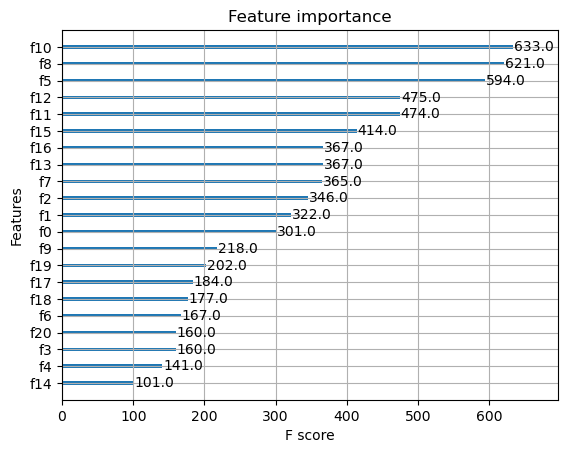

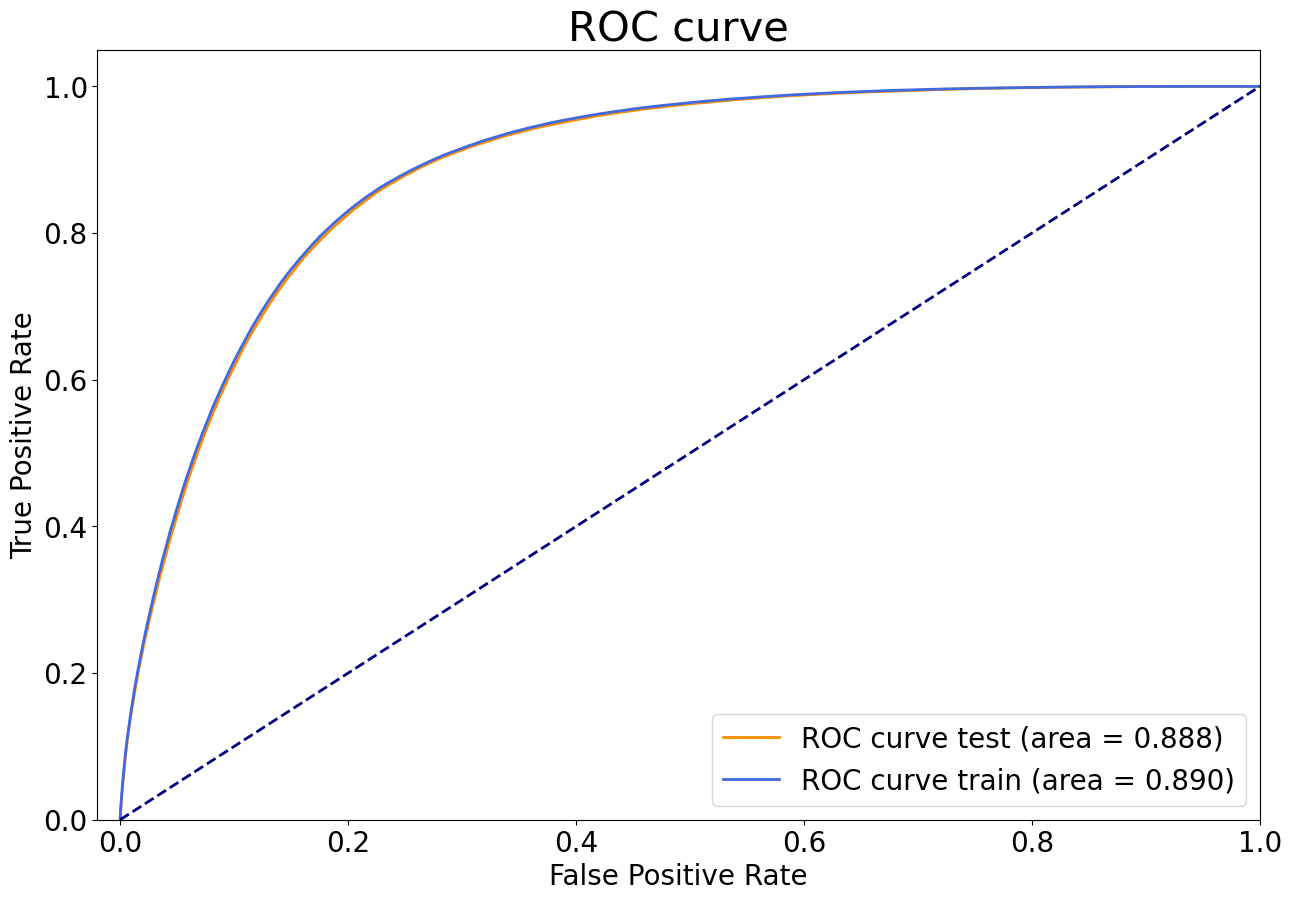

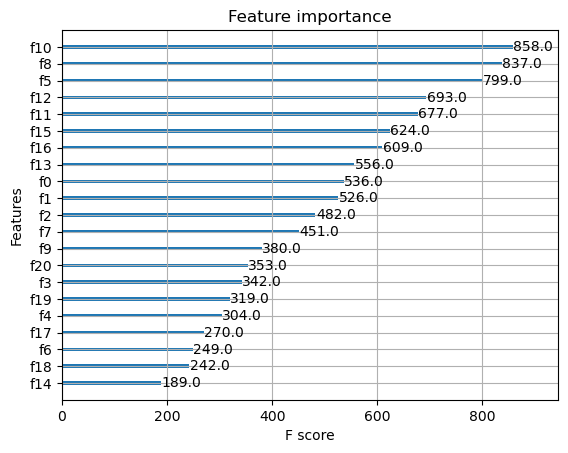

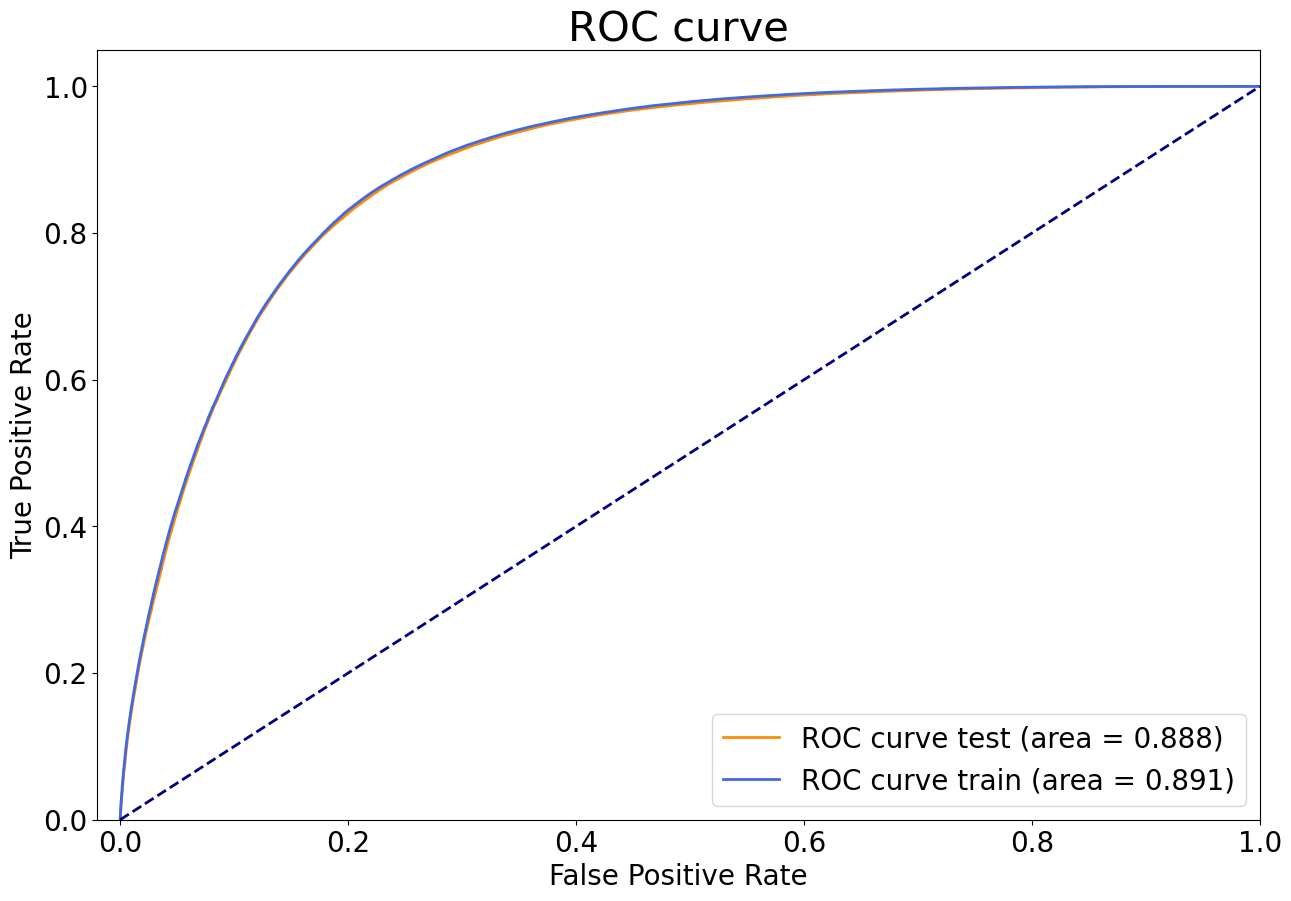

In [21]:
# Compute micro-average ROC curve and ROC area
for i, MC in enumerate(MC_events_kfold): 
    fpr, tpr, _ = roc_curve(MC[select_test[i]]["label"], check[i], sample_weight=abs(MC[select_test[i]]["weight_train"]))
    fpr_train, tpr_train, _train = roc_curve(MC[select_train[i]]["label"], check_train[i], sample_weight=abs(MC[select_train[i]]["weight_train"]))
    roc_auc = auc(fpr, tpr)
    roc_auc_train = auc(fpr_train, tpr_train)
    xgboost.plot_importance(bdt[i])
    lw = 2
    fig = plt.figure(figsize=(15,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve test (area = %0.3f)' % roc_auc)
    plt.plot(fpr_train, tpr_train, color='royalblue',
             lw=lw, label='ROC curve train (area = %0.3f)' % roc_auc_train)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.title('ROC curve', fontsize=30)
    plt.legend(loc="lower right", fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.show()
    fig.savefig(f"plots/ROC_{model_name}_{i}.pdf")

Then with the correct normalisation

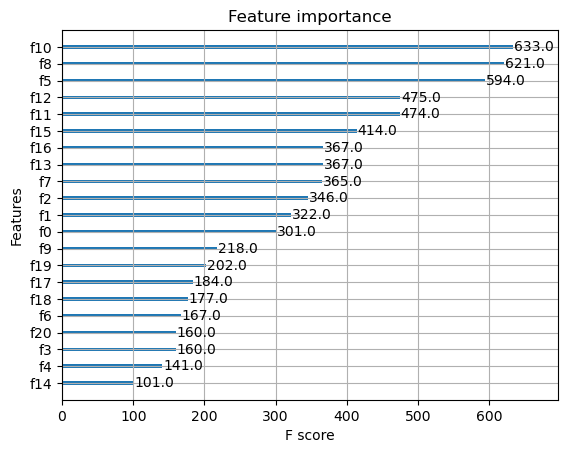

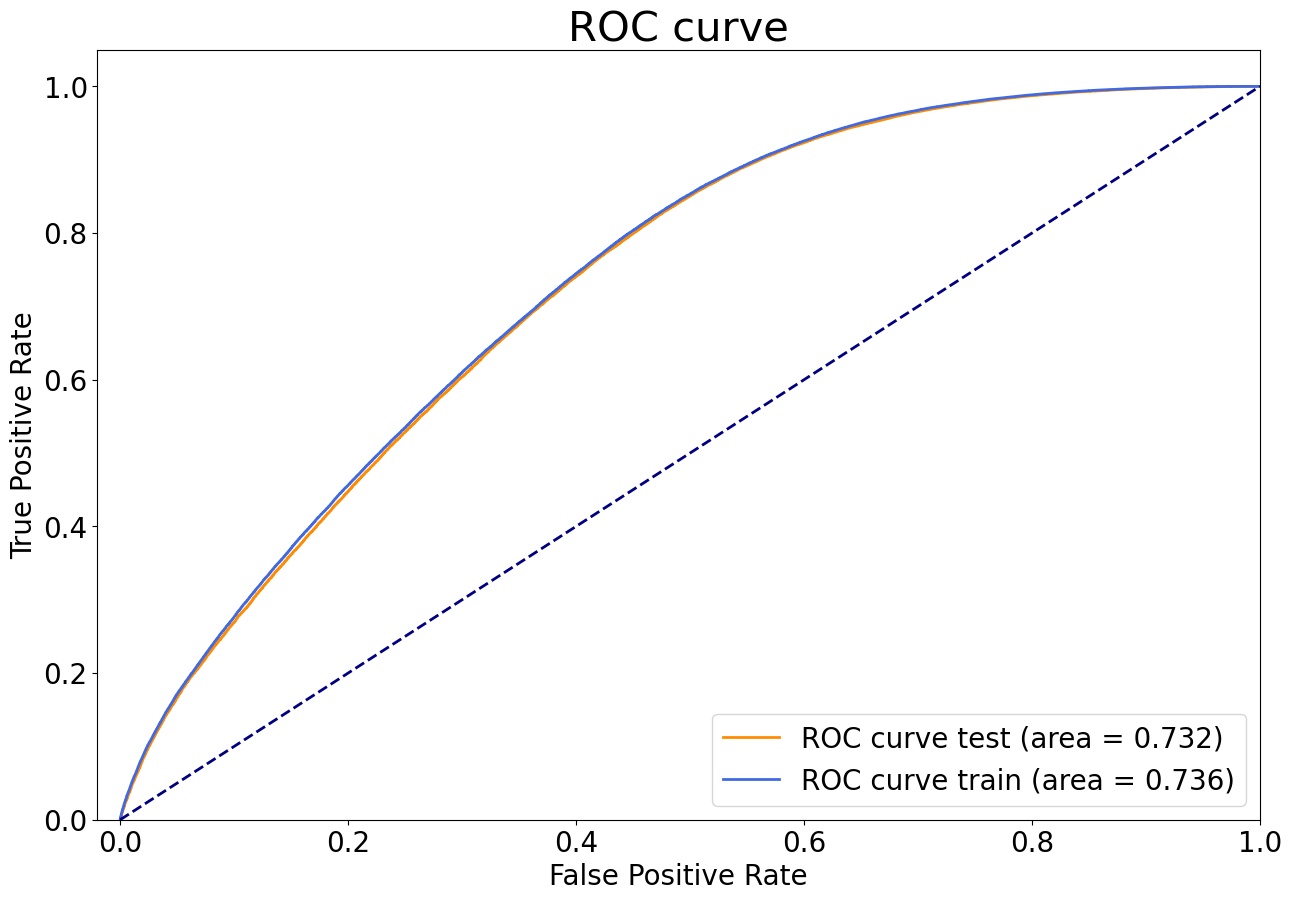

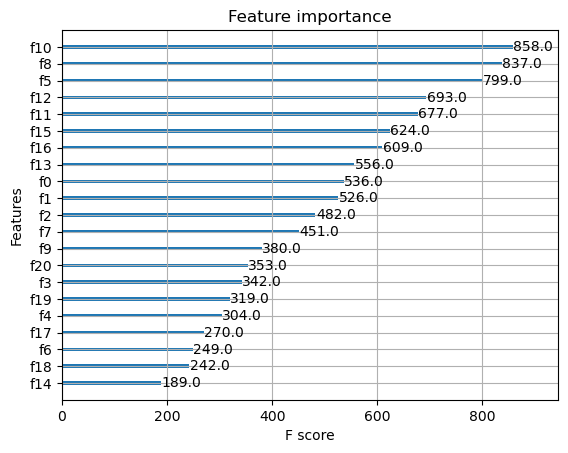

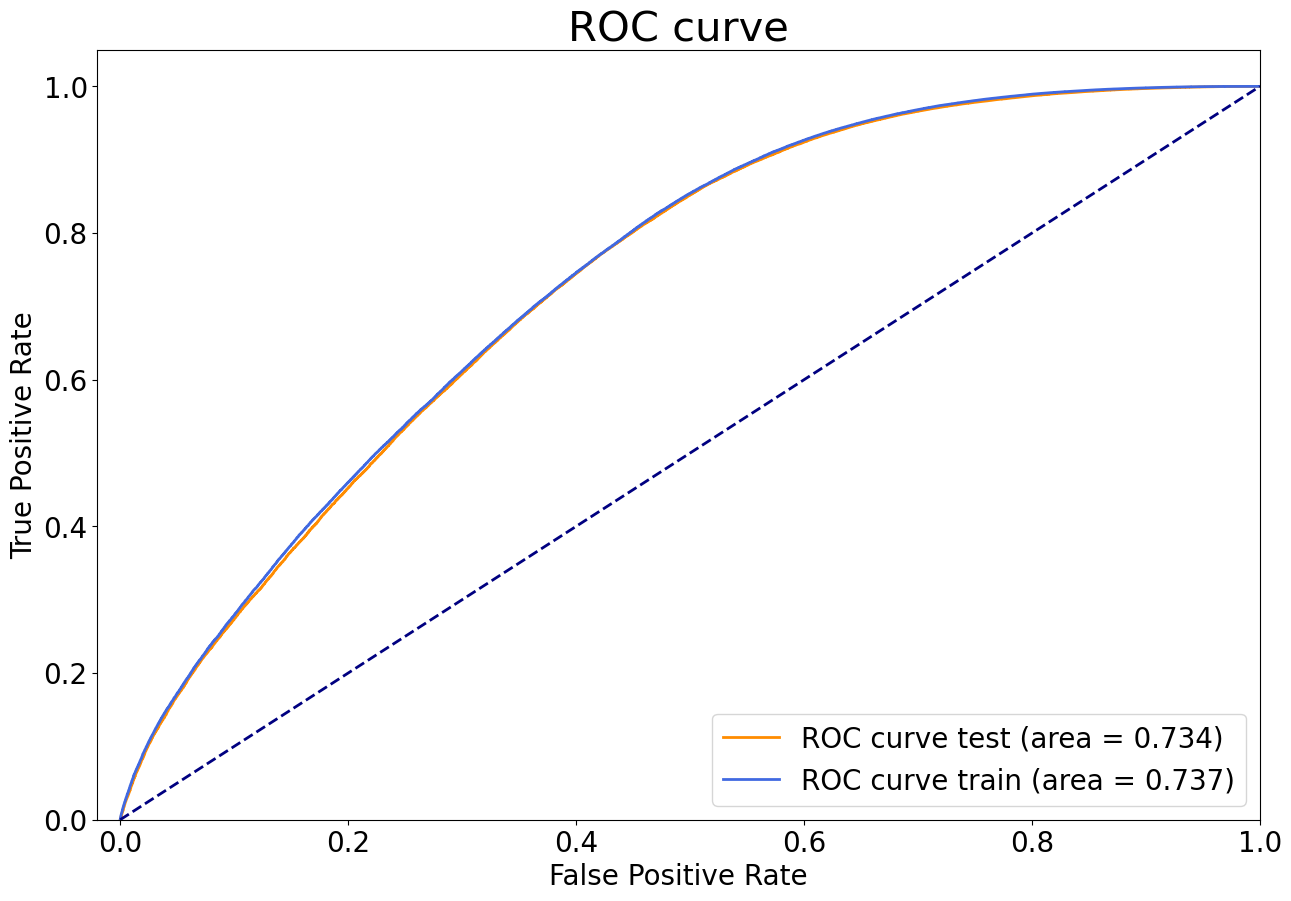

In [22]:
# Compute micro-average ROC curve and ROC area
for i, MC in enumerate(MC_events_kfold): 
    fpr, tpr, _ = roc_curve(MC[select_test[i]]["label"], check[i], sample_weight=abs(MC[select_test[i]]["weight"]))
    fpr_train, tpr_train, _train = roc_curve(MC[select_train[i]]["label"], check_train[i], sample_weight=abs(MC[select_train[i]]["weight"]))
    roc_auc = auc(fpr, tpr)
    roc_auc_train = auc(fpr_train, tpr_train)
    xgboost.plot_importance(bdt[i])
    lw = 2
    fig = plt.figure(figsize=(15,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve test (area = %0.3f)' % roc_auc)
    plt.plot(fpr_train, tpr_train, color='royalblue',
             lw=lw, label='ROC curve train (area = %0.3f)' % roc_auc_train)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.title('ROC curve', fontsize=30)
    plt.legend(loc="lower right", fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.show()
    fig.savefig(f"plots/ROC_true_wgt_{model_name}_{i}.pdf")

## Evaluation of the score on the opposite sample for validation...

In [23]:
# Predict
for i, MC in enumerate(MC_events_kfold):
    features = awkward.to_numpy(MC[bdt_config["features"]])
    features = features.view((float, len(features.dtype.names)))
    if i == 0:
        MC["mva_score"] = bdt[1].predict(xgboost.DMatrix(features))
    else:
        MC["mva_score"] = bdt[0].predict(xgboost.DMatrix(features))

## ... and reassembly of the array

In [24]:
features = awkward.to_numpy(MC_events[bdt_config["features"]])
features = features.view((float, len(features.dtype.names)))
bdt_score_0 = bdt[1].predict(xgboost.DMatrix(features))
bdt_score_1 = bdt[0].predict(xgboost.DMatrix(features))

MC_events["mva_score"] = ak.where(
    MC_events.event % 2 == 0,
    bdt_score_0,
    bdt_score_1
)

## weight for plotting MC errors

In [25]:
for i, MC in enumerate(MC_events_kfold):
        MC["square_weight"] = MC.weight ** 2

In [26]:
MC_events["square_weight"] = MC_events.weight ** 2

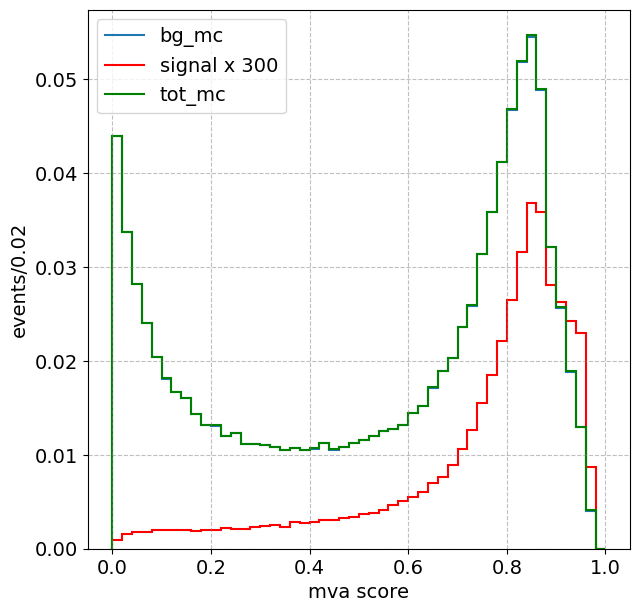

<Figure size 640x480 with 0 Axes>

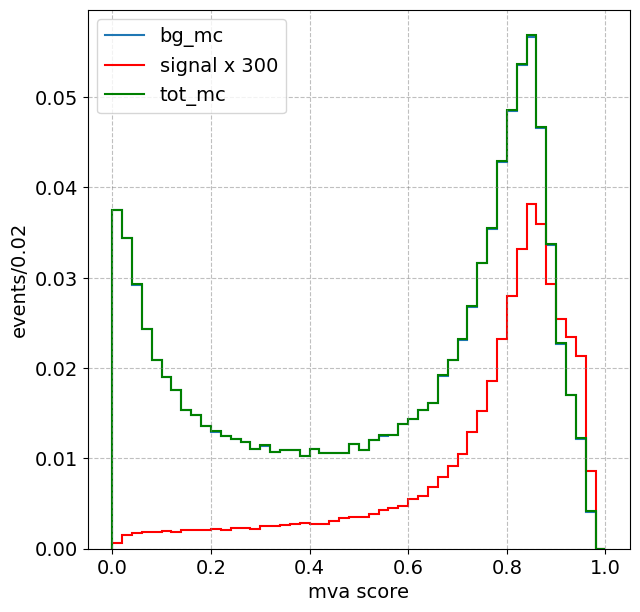

<Figure size 640x480 with 0 Axes>

In [28]:
#bdt_score
for i, MC in enumerate(MC_events_kfold):
    fig, axs = plt.subplots(1,1, figsize=(7, 7))
    min_ = 0
    max_ = 1
    nbins = 50
    h_bdt_score_tot = hist.Hist(hist.axis.Regular(bins=nbins, start=min_, stop=max_, name="bdt_score_tot", label="tot"))
    h_bdt_score_tot_err = hist.Hist(hist.axis.Regular(bins=nbins, start=min_, stop=max_, name="bdt_score_tot", label="tot"))
    h_bdt_score_sig = hist.Hist(hist.axis.Regular(bins=nbins, start=min_, stop=max_, name="bdt_score_tot", label="tot"))
    h_bdt_score_bg = hist.Hist(hist.axis.Regular(bins=nbins, start=min_, stop=max_, name="bdt_score_tot", label="tot"))
    h_bdt_score_tot.fill(bdt_score_tot = MC.mva_score, weight = MC.weight/ak.sum(MC.weight))
    #h_bdt_score_tot.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id > -3)], weight = MC_events.weight[(MC_events.proc_id > -3)])
    #h_bdt_score_tot.fill(bdt_score_tot = qcd.mva_score, weight = qcd.weight)
    h_bdt_score_tot_err.fill(bdt_score_tot = MC.mva_score, weight = MC.square_weight)
    h_bdt_score_sig.fill(bdt_score_tot = MC.mva_score[(MC.label == 1)], weight = MC.weight[(MC.label == 1)]/ak.sum(MC.weight))
    h_bdt_score_bg.fill( bdt_score_tot = MC.mva_score[(MC.label == 0)], weight = MC.weight[(MC.label == 0)]/ak.sum(MC.weight))

    h_bdt_score_sig = h_bdt_score_sig * 300 

    h_bdt_score_bg.project("bdt_score_tot").plot(ax=axs, label="bg_mc")
    h_bdt_score_sig.project("bdt_score_tot").plot(ax=axs, color="red", label="signal x 300")
    h_bdt_score_tot.project("bdt_score_tot").plot(ax=axs, color="green", label="tot_mc")


    axs.legend( prop={'size': 14})
    axs.grid(color='grey', linestyle='--', alpha=0.5)
    axs.set_ylabel('events')
    # axs.set_yscale('log')
    axs.set_xlabel('mva score', fontsize=14)
    axs.set_ylabel('events/0.02', fontsize=14)
    axs.tick_params(axis='x', labelsize=14)
    axs.tick_params(axis='y', labelsize=14)

    plt.plot()
    plt.show()
    plt.savefig(f"plots/mva_score_sig_bg_{model_name}.pdf")

## Signal vs Background efficiency plots 

In [29]:
sig_fpr = []
sig_tpr = []
frac_sob = []
cuts = []
MC_events["weight_train"] = ak.ones_like(MC_events.weight)

ch = MC_events[MC_events.proc_id == 5]
ggh = MC_events[MC_events.proc_id == 1]
sum_sig = ak.sum(ch["weight_train"])
sum_bkg = ak.sum(ggh["weight_train"])

for i in range(80):
    step = 1/80.
    cuts.append(i * step)
    if i == 0:
        print(f'tot events = {len(ch)+len(ggh)}, signal event number = {len(ch)}, ggh event number = {len(ggh)}')

    pass_sig = ak.sum(ch["weight_train"][ch["mva_score"] > i * step])
    pass_bkg = ak.sum(ggh["weight_train"][ggh["mva_score"] > i * step])

    #print(f"|----> signal: {signal}")
    #print(f"|--------> passing fraction first_jet_DeepFlavour_CvsL = {pass_deepjet_sig/sum_sig:.3f}")
    #print(f"|--------> passing fraction first_jet_particleNetAK4_CvsL = {pass_pnet_sig/sum_sig:.3f}")
    sig_tpr.append(pass_sig/sum_sig)
    #print(f"|----> background: {signal}")
    #print(f"|----> passing fraction first_jet_DeepFlavour_CvsL = {pass_deepjet_bkg/sum_bkg:.3f}")
    # print(f"|----> passing fraction first_jet_particleNetAK4_CvsL = {pass_pnet_bkg/sum_bkg:.3f}")
    sig_fpr.append(pass_bkg/sum_bkg)
    # print(f"|----> sig/bkg")
    # print(f"|----> passing fraction first_jet_DeepFlavour_CvsL = {(pass_deepjet_sig/sum_sig)/(pass_deepjet_bkg/sum_bkg):.3f}")
    # print(f"|----> passing fraction first_jet_particleNetAK4_CvsL = {(pass_pnet_sig/sum_sig)/(pass_pnet_bkg/sum_bkg):.3f}")
    frac_sob.append((pass_sig/sum_sig)/(pass_bkg/sum_bkg))


tot events = 1544836, signal event number = 1281864, ggh event number = 262972


/tmp/ipykernel_27095/9399630.py:32: RuntimeWarning: invalid value encountered in double_scalars
  frac_sob.append((pass_sig/sum_sig)/(pass_bkg/sum_bkg))


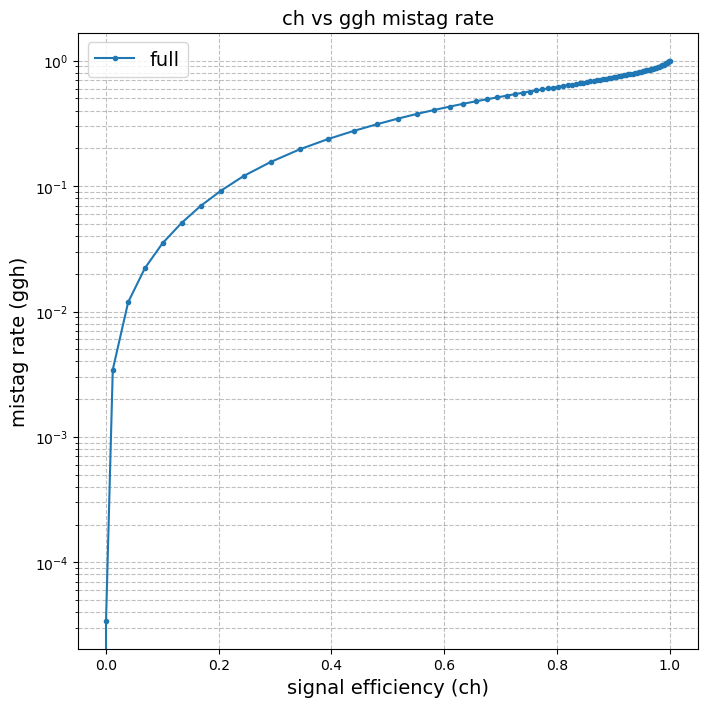

In [30]:
fig = plt.figure(figsize=(8, 8))
plt.title(f"ch vs ggh mistag rate", fontsize=14)
plt.plot(sig_tpr, sig_fpr, marker='.', label="full")
plt.legend(fontsize=14)
plt.ylabel("mistag rate (ggh)", fontsize=14)
plt.xlabel("signal efficiency (ch)", fontsize=14)
plt.yscale("log")
plt.grid(color='grey', linestyle='--', alpha=0.5, which='both')

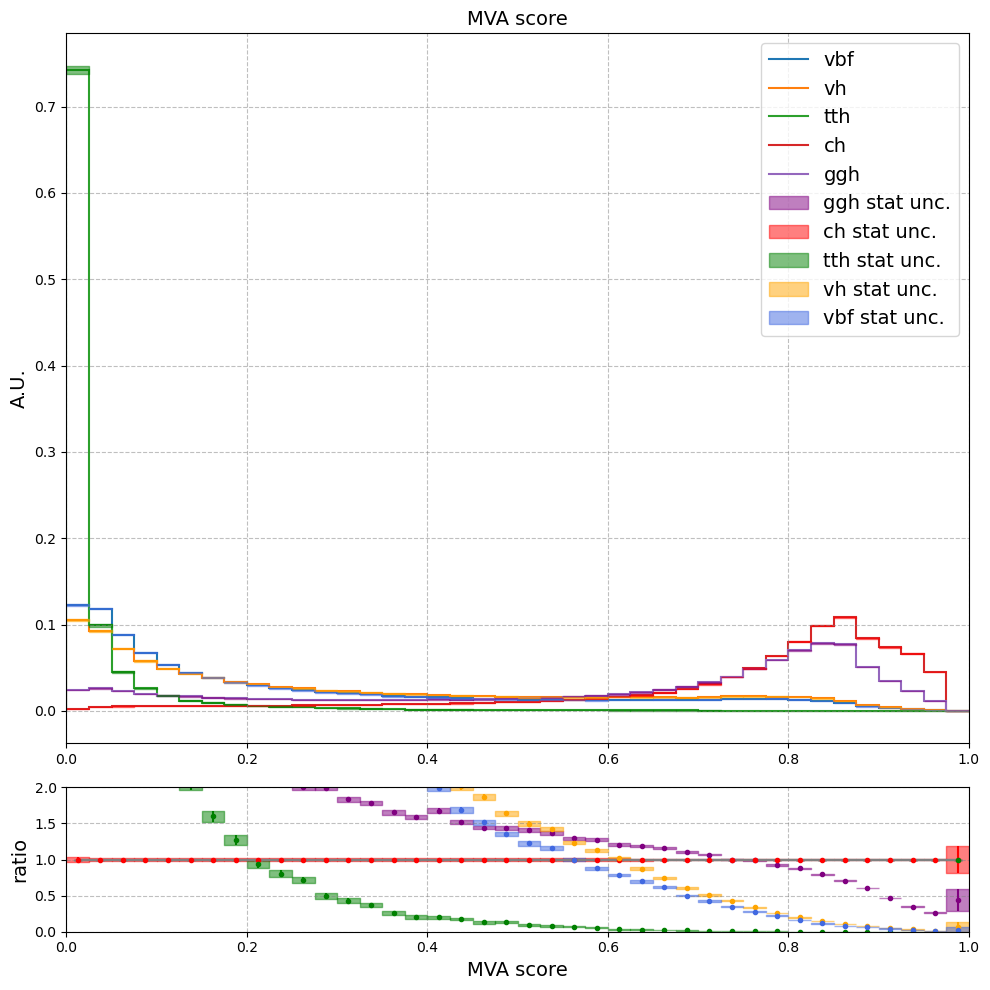

<Figure size 640x480 with 0 Axes>

In [31]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "mva_score"
min_ = 0.
max_ = 1
nbins = 40

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch", "tth", "vh", "vbf"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
norm["tth"] = ak.sum(MC_events.weight[(MC_events.proc_id == 2)])
norm["vh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 4)])
norm["vbf"] = ak.sum(MC_events.weight[(MC_events.proc_id == 3)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 2)], weight=MC_events.weight[(MC_events.proc_id == 2)]/norm["tth"], c="tth")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 4)], weight=MC_events.weight[(MC_events.proc_id == 4)]/norm["vh"], c="vh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 3)], weight=MC_events.weight[(MC_events.proc_id == 3)]/norm["vbf"], c="vbf")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 2)], weight=MC_events.square_weight[(MC_events.proc_id == 2)], c="tth")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 4)], weight=MC_events.square_weight[(MC_events.proc_id == 4)], c="vh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 3)], weight=MC_events.square_weight[(MC_events.proc_id == 3)], c="vbf")


h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch", "tth", "vh", "vbf"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in ["ggh", "ch", "tth", "vh", "vbf"]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]

# plot shaded area for MC errors
colours = ["royalblue", "orange", "green", "red", "purple"]
for j, sample in enumerate(["ggh", "ch", "tth", "vh", "vbf"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[-(j+1)], alpha=0.5, edgecolor=colours[-(j+1)], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[-(j+1)], alpha=0.5, edgecolor=colours[-(j+1)], label="")

# cosmetics
ax0.set_ylabel('A.U.', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('MVA score', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

for j, sample in enumerate(["ggh", "ch", "tth", "vh", "vbf"]):
    ratio = ak.where(
        mc["bins"][sample] != 0,
        mc["bins"][sample] / mc["bins"]["ch"],
        ak.ones_like(mc["bins"][sample])
    )
    ax1.plot(mc["edges"][sample][:-1], ak.ones_like(mc["bins"][sample]), color="grey", marker="_", linestyle="-", label="mc")
    ax1.errorbar(mc["edges"][sample][:-1], ratio, yerr = mc["errs"][sample]/mc["bins"]["ch"], color=colours[-(j+1)], marker=".", linestyle="", label=sample)

    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[-(j+1)], alpha=0.5, edgecolor=colours[-(j+1)], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('MVA score', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
plt.savefig(f"plots/mva_score_dist_{model_name}.pdf")

## Input variables plots

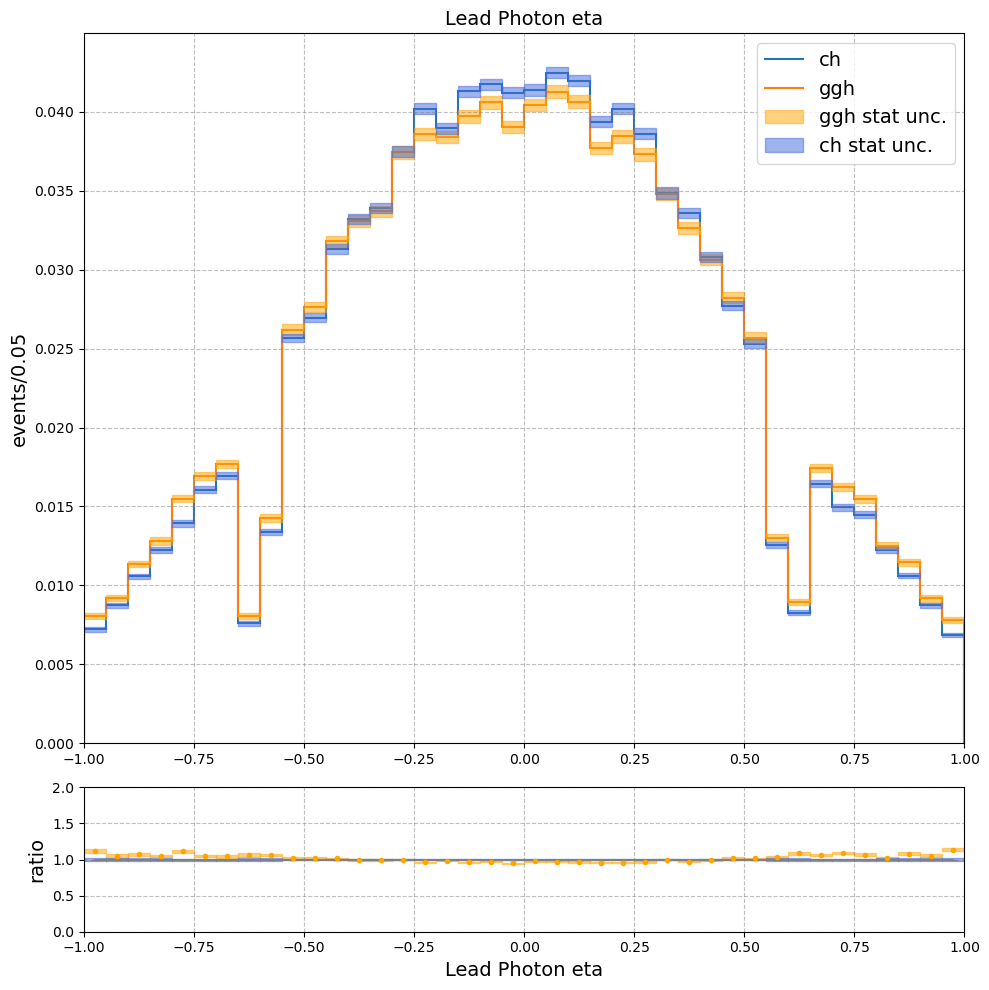

In [56]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "LeadPhoton_eta"
min_ = -1.
max_ = 1
nbins = 40

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Lead Photon eta', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('Lead Photon eta', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_14194/3264961928.py:101: RuntimeWarning: divide by zero encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_14194/3264961928.py:101: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_14194/3264961928.py:105: RuntimeWarning: divide by zero encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_14194/3264961928.py:105: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")


ValueError: 'yerr' must not contain negative values

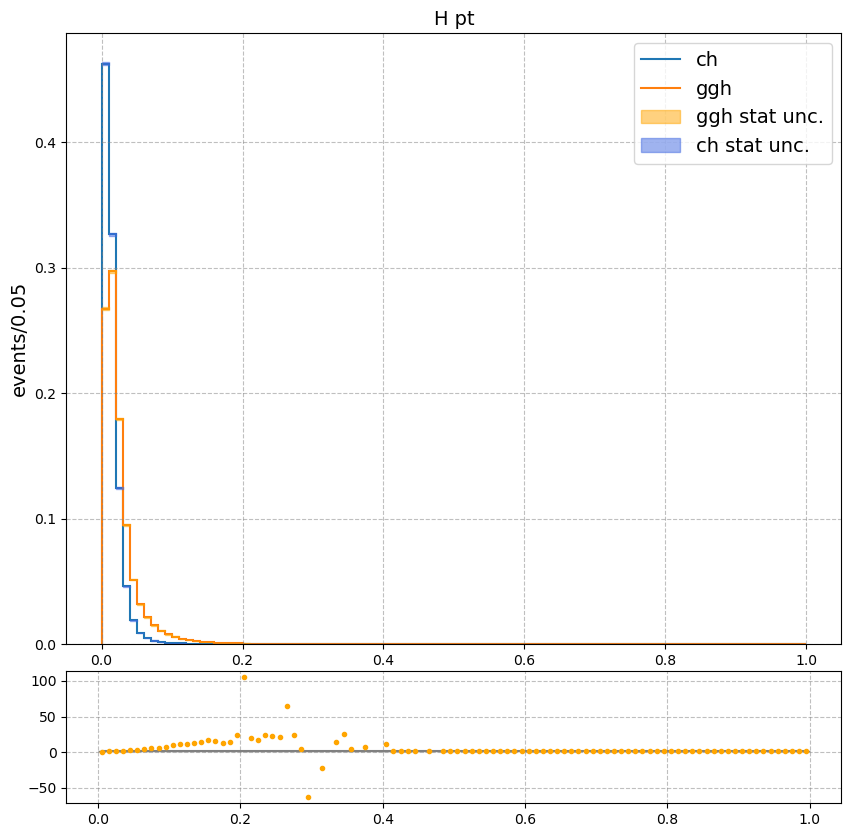

In [57]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "pt"
title = ""
for x in var.split("_"):
    title = title + x
title = "H pt"
min_ = 0.
max_ = 1
nbins = 100

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

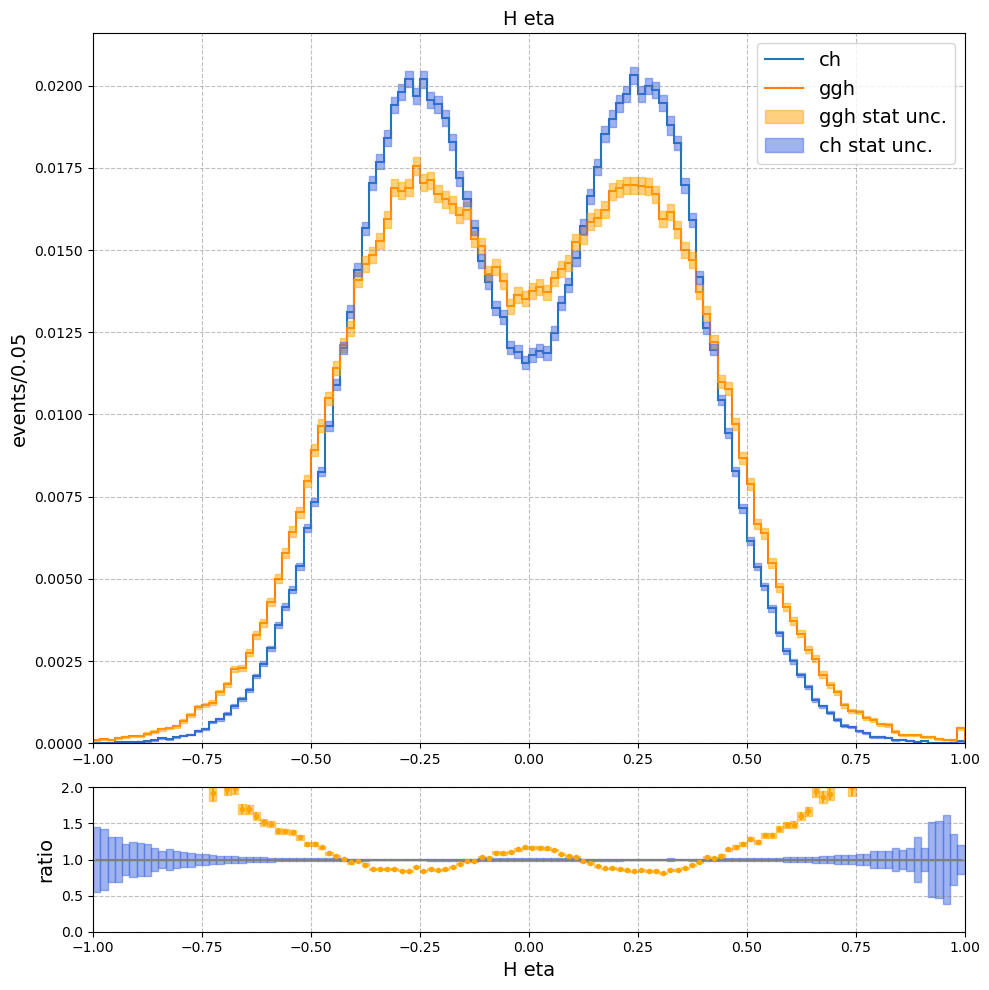

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "eta"
title = ""
for x in var.split("_"):
    title = title + x
title = "H eta"
min_ = -1.
max_ = 1
nbins = 120

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

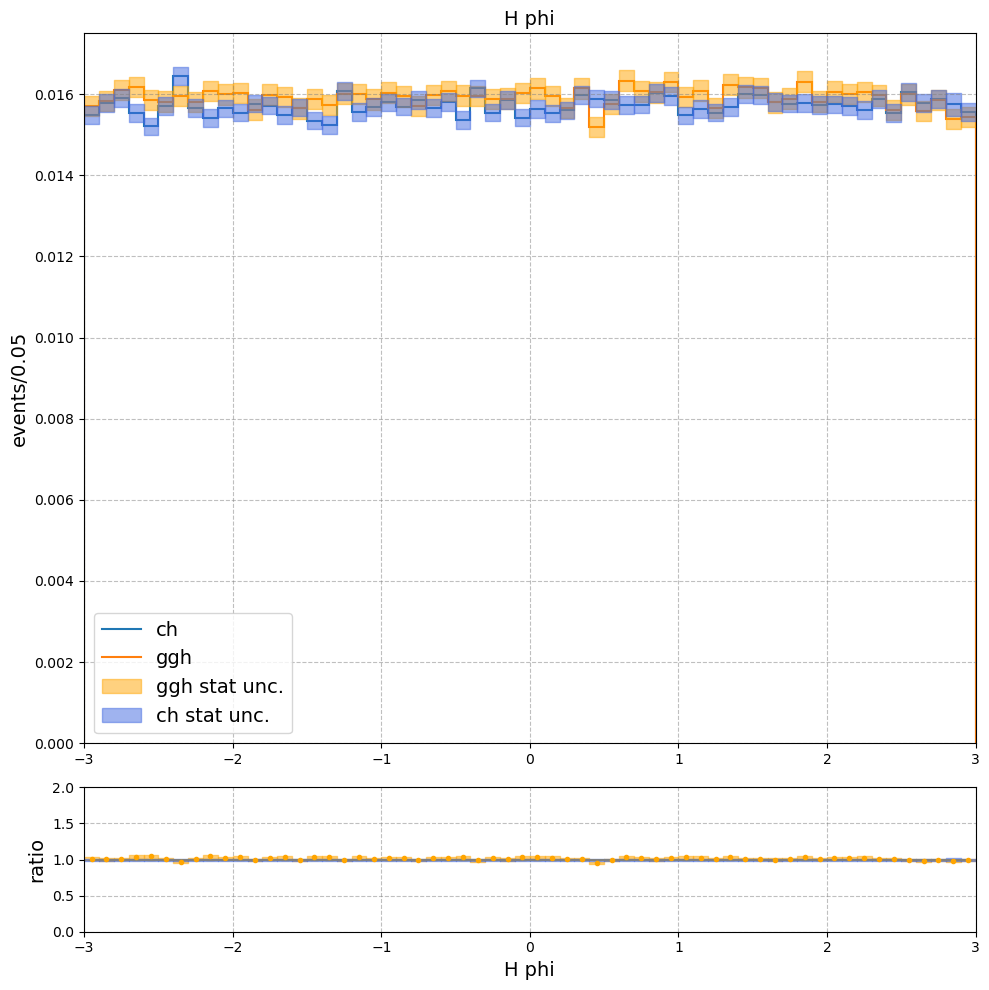

In [58]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "phi"
title = ""
for x in var.split("_"):
    title = title + x
title = "H phi"
min_ = -3.
max_ = 3
nbins = 60

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_14194/3686251770.py:100: RuntimeWarning: divide by zero encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_14194/3686251770.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_14194/3686251770.py:104: RuntimeWarning: divide by zero encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_14194/3686251770.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")
/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3680: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_14194/3686251770.py:10

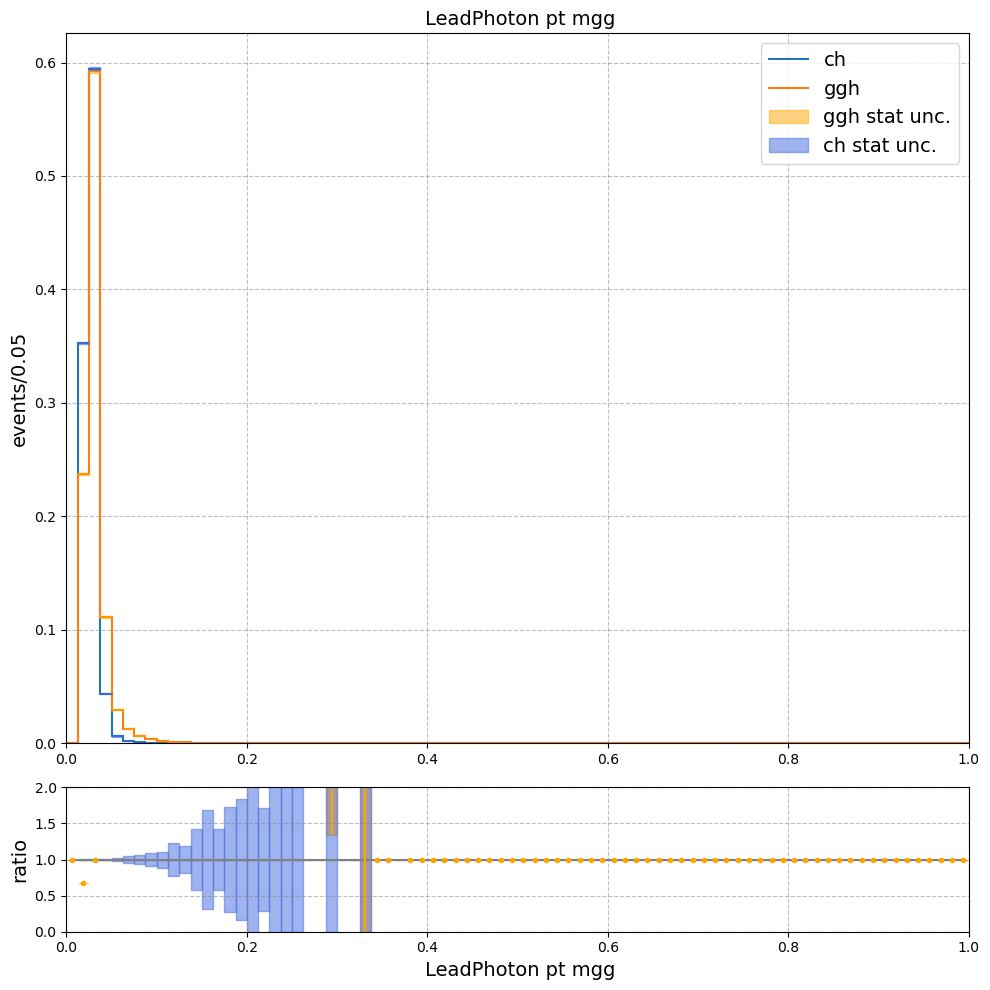

In [59]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "LeadPhoton_pt_mgg"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0.
max_ = 1
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_14194/4290934473.py:100: RuntimeWarning: divide by zero encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_14194/4290934473.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_14194/4290934473.py:104: RuntimeWarning: divide by zero encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_14194/4290934473.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3680: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_14194/429093

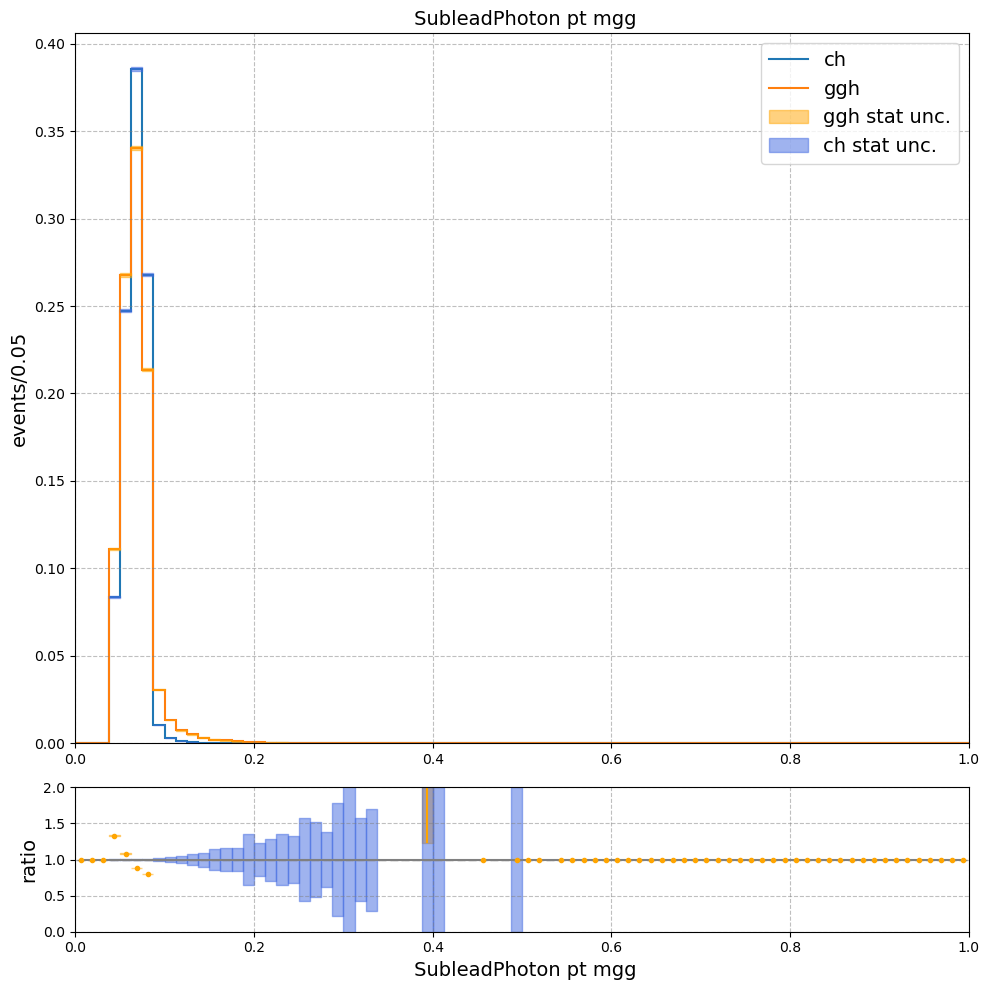

In [60]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "SubleadPhoton_pt_mgg"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0.
max_ = 1
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

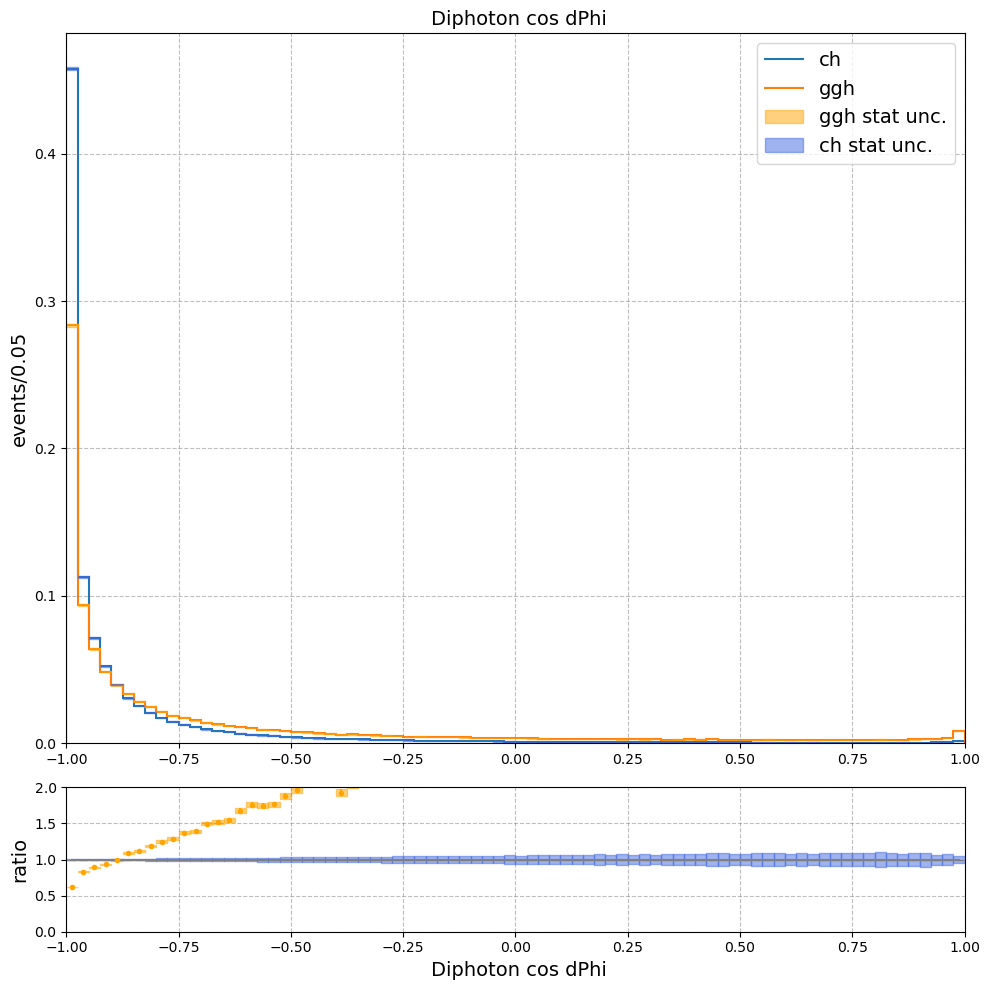

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "Diphoton_cos_dPhi"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = -1.
max_ = 1
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_57918/1163827082.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/1163827082.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_57918/1163827082.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


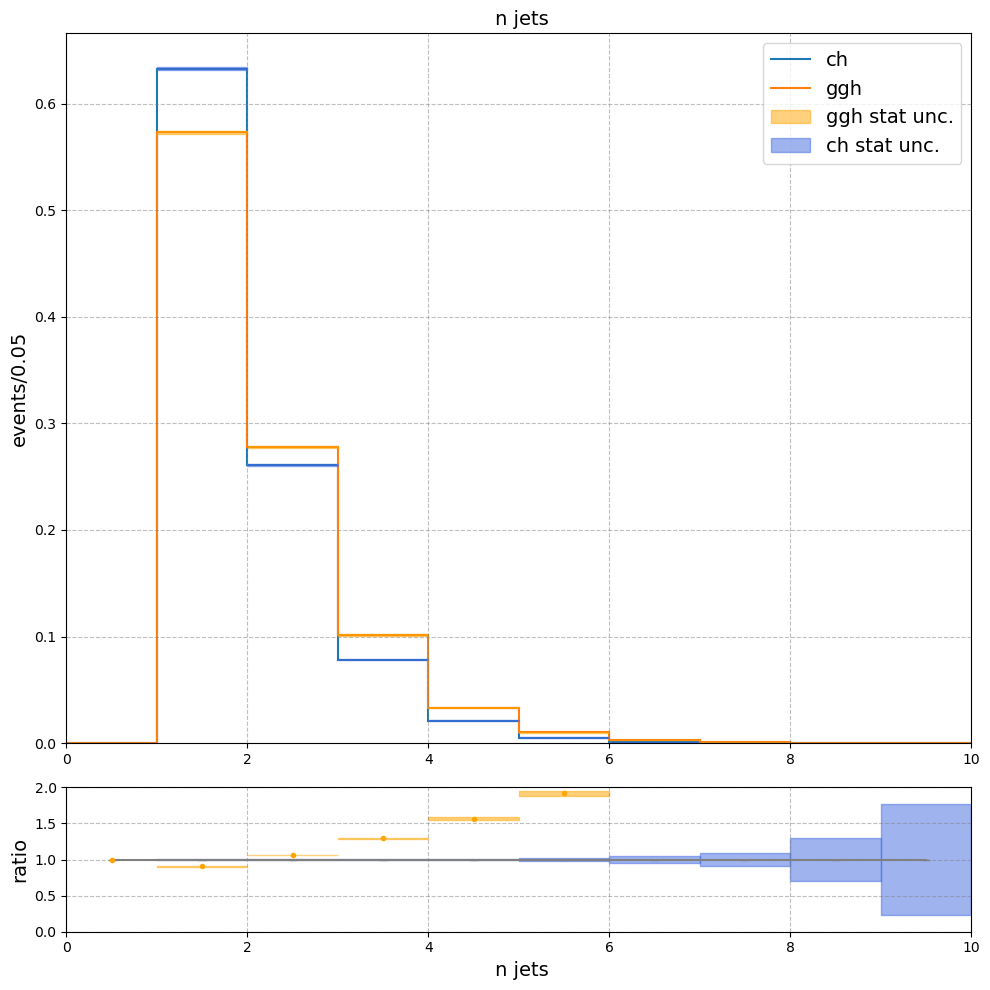

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "n_jets"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0.
max_ = 10
nbins = 10

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_57918/1724271096.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/1724271096.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")


ValueError: 'yerr' must not contain negative values

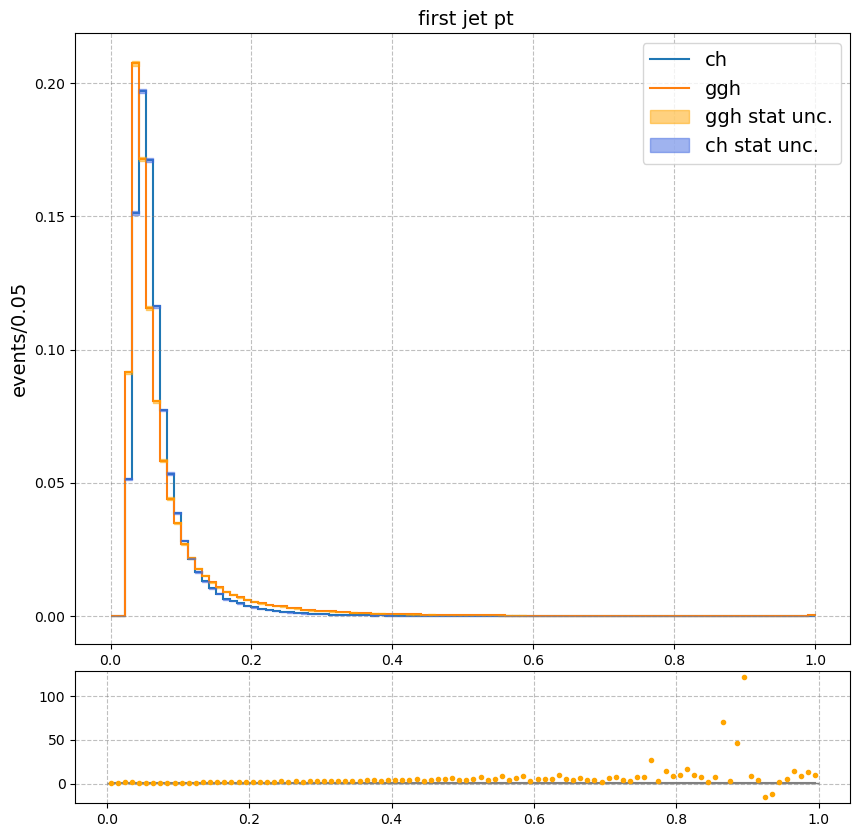

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_jet_pt"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0.
max_ = 1
nbins = 100

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_57918/1218169719.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/1218169719.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_57918/1218169719.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


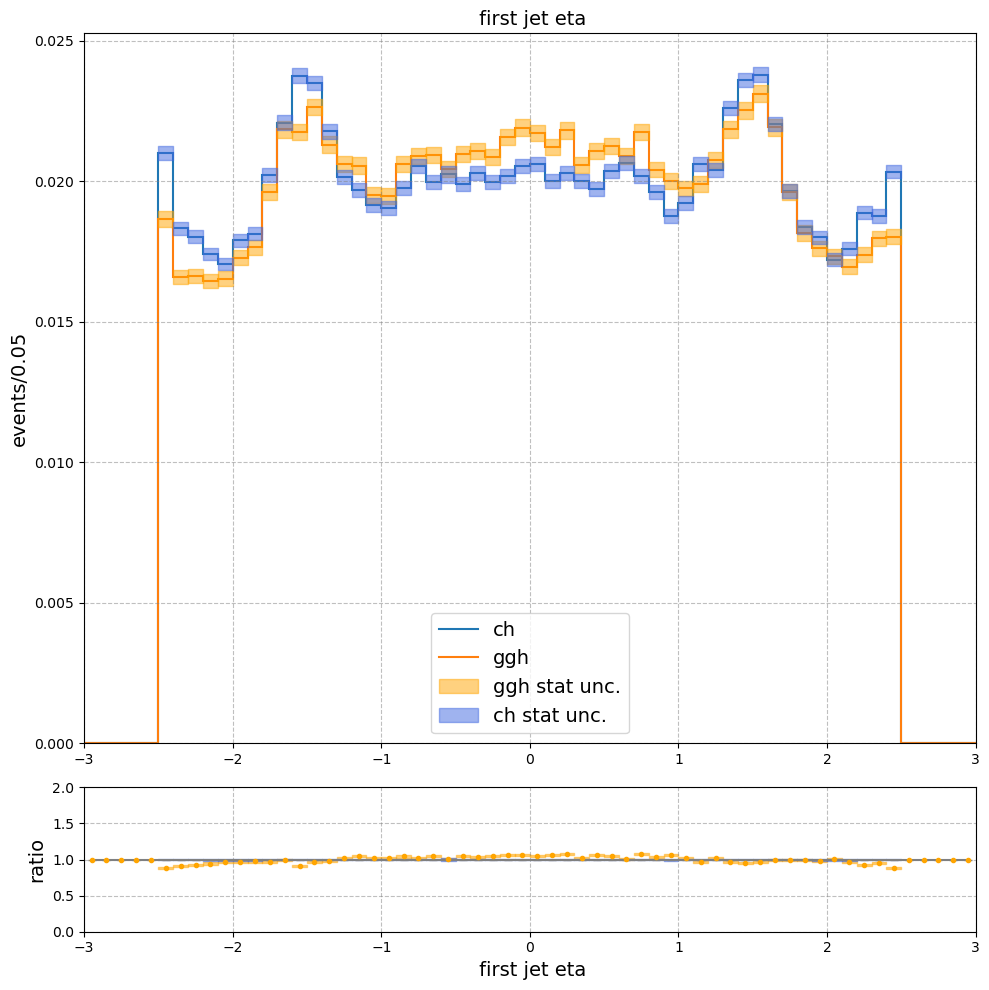

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_jet_eta"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = -3.
max_ = 3
nbins = 60

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_57918/1603542244.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/1603542244.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_57918/1603542244.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


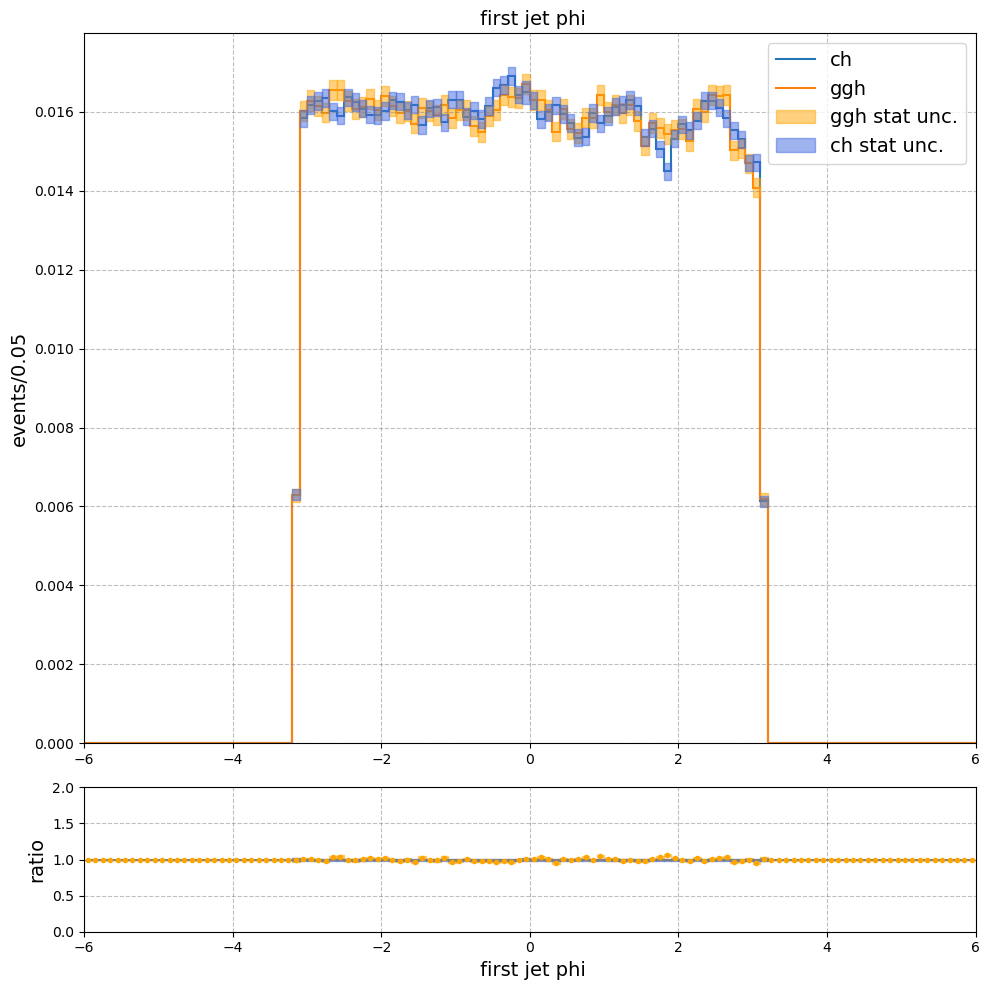

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_jet_phi"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = -6
max_ = 6
nbins = 120

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

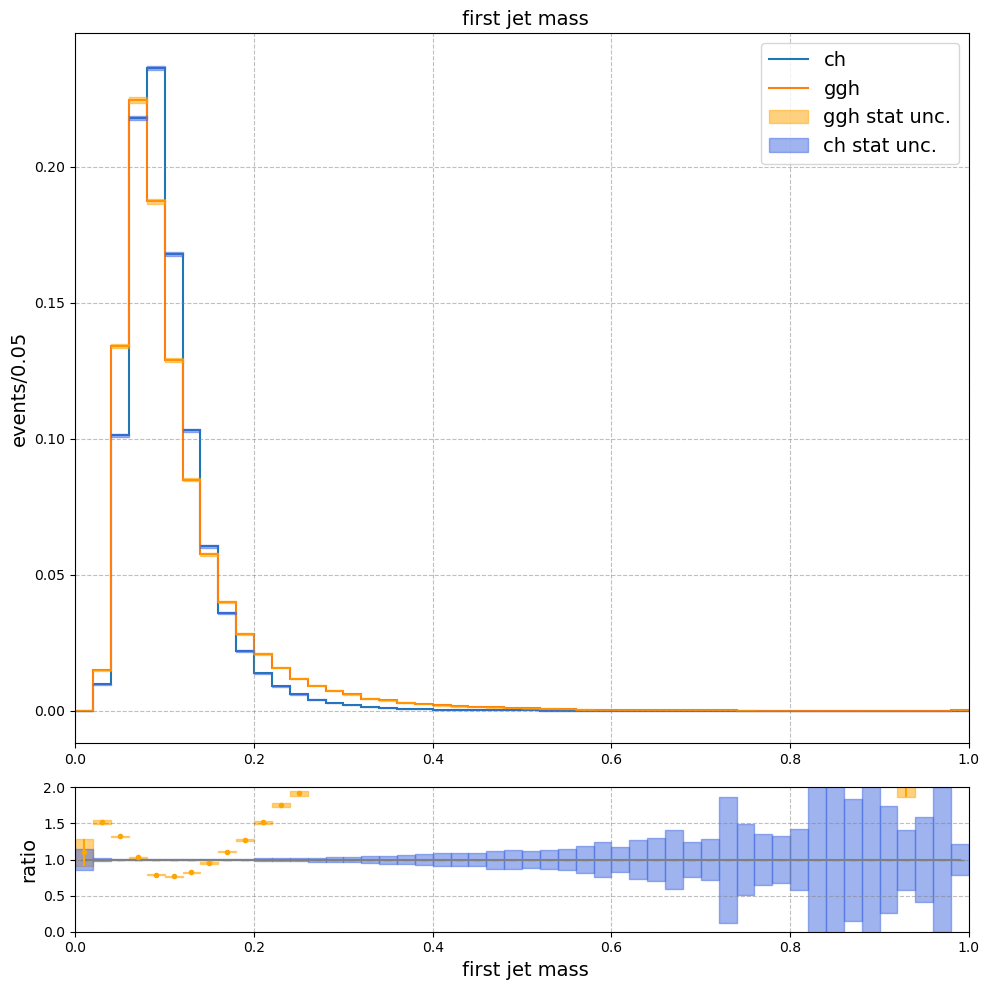

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_jet_mass"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 1
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

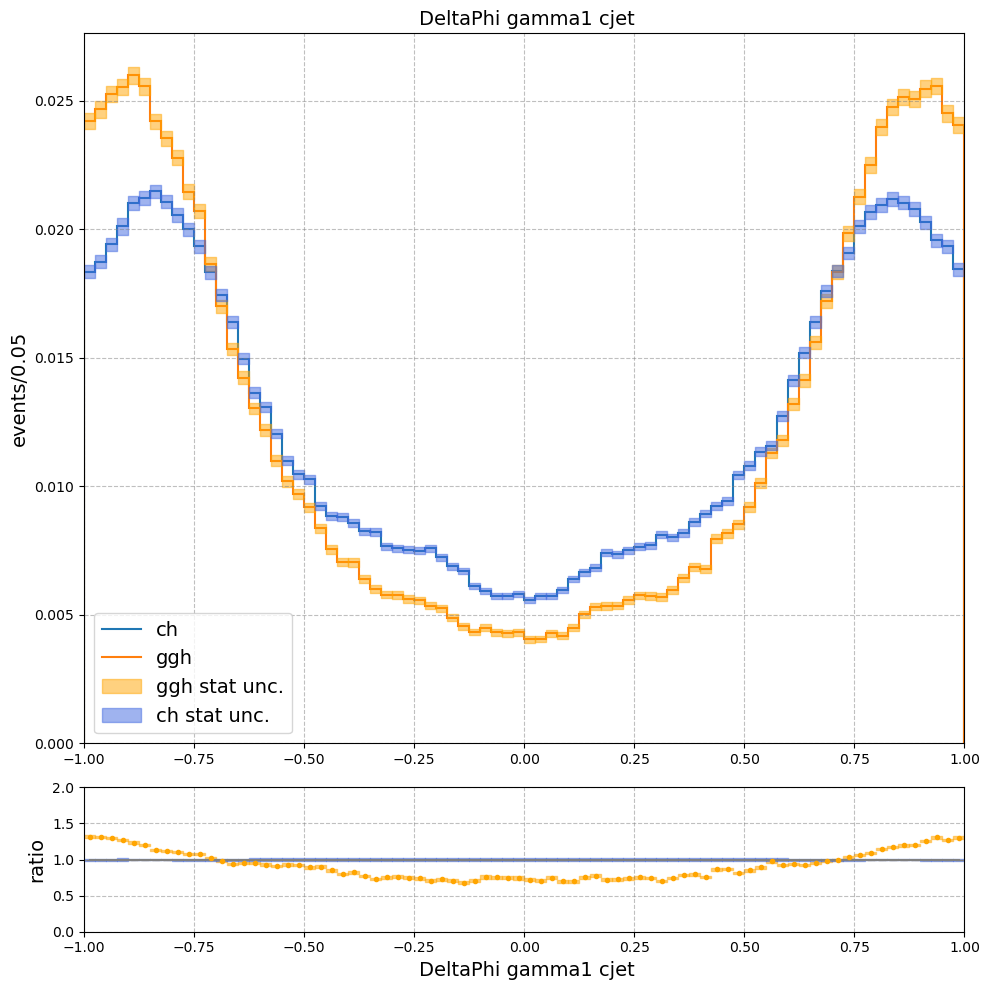

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "DeltaPhi_gamma1_cjet"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = -1
max_ = 1
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

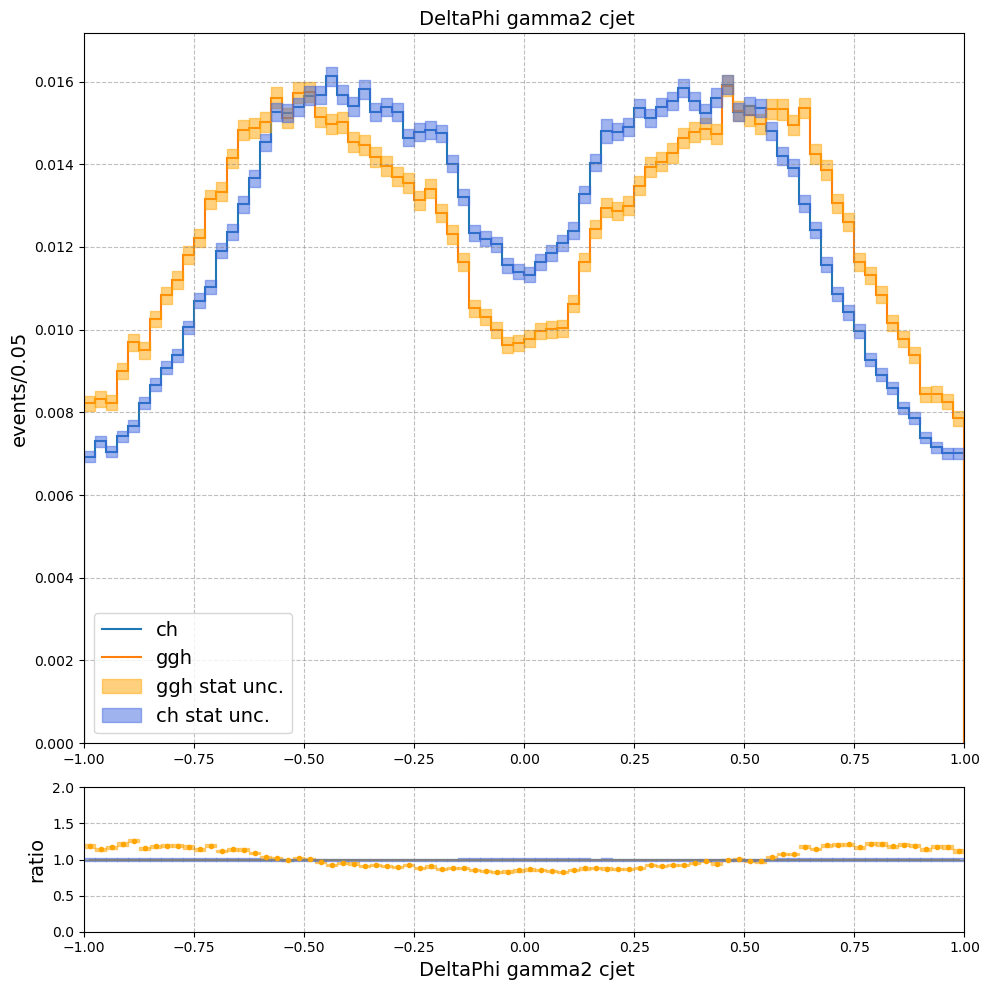

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "DeltaPhi_gamma2_cjet"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = -1
max_ = 1
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_57918/3482303884.py:100: RuntimeWarning: divide by zero encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/3482303884.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/3482303884.py:104: RuntimeWarning: divide by zero encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_57918/3482303884.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/work/bevila_t/MINICONDA3/envs/higgs-dna/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3683: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_57918/3482303884

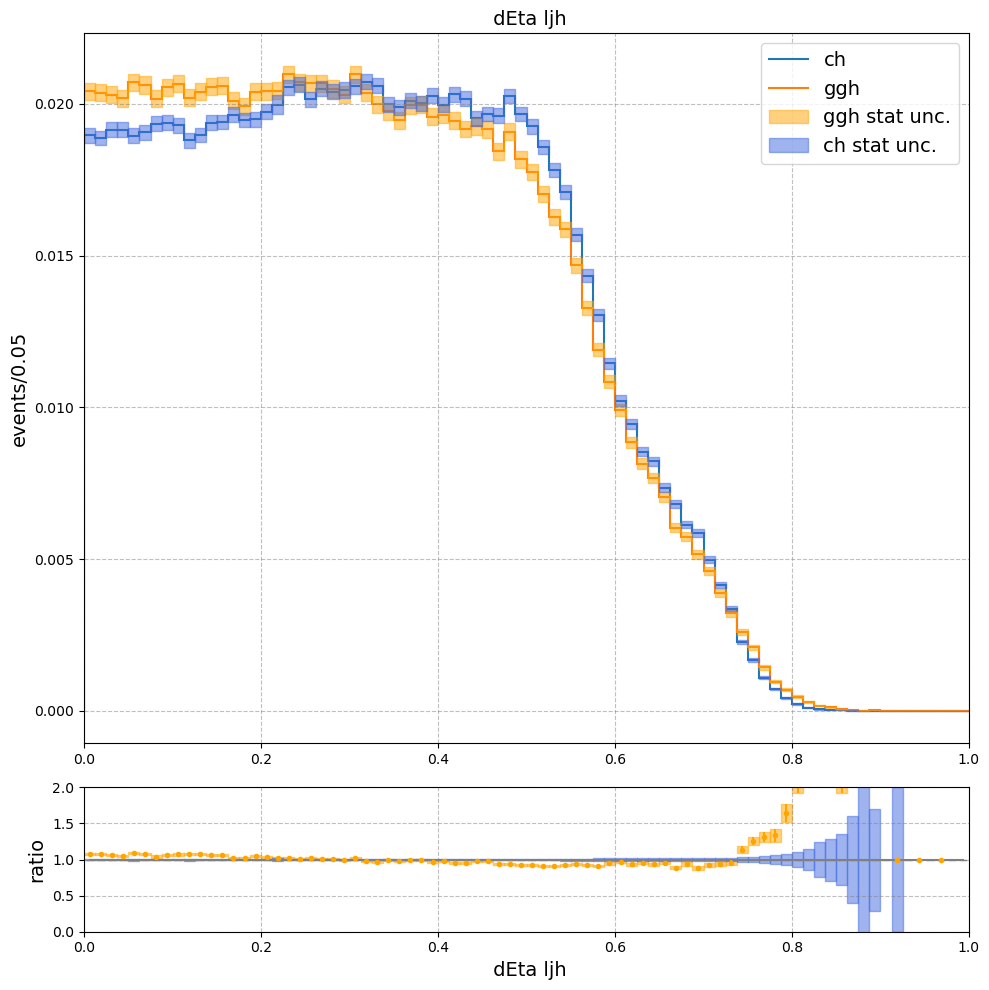

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "dEta_ljh"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 1
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_57918/993858169.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/993858169.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_57918/993858169.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


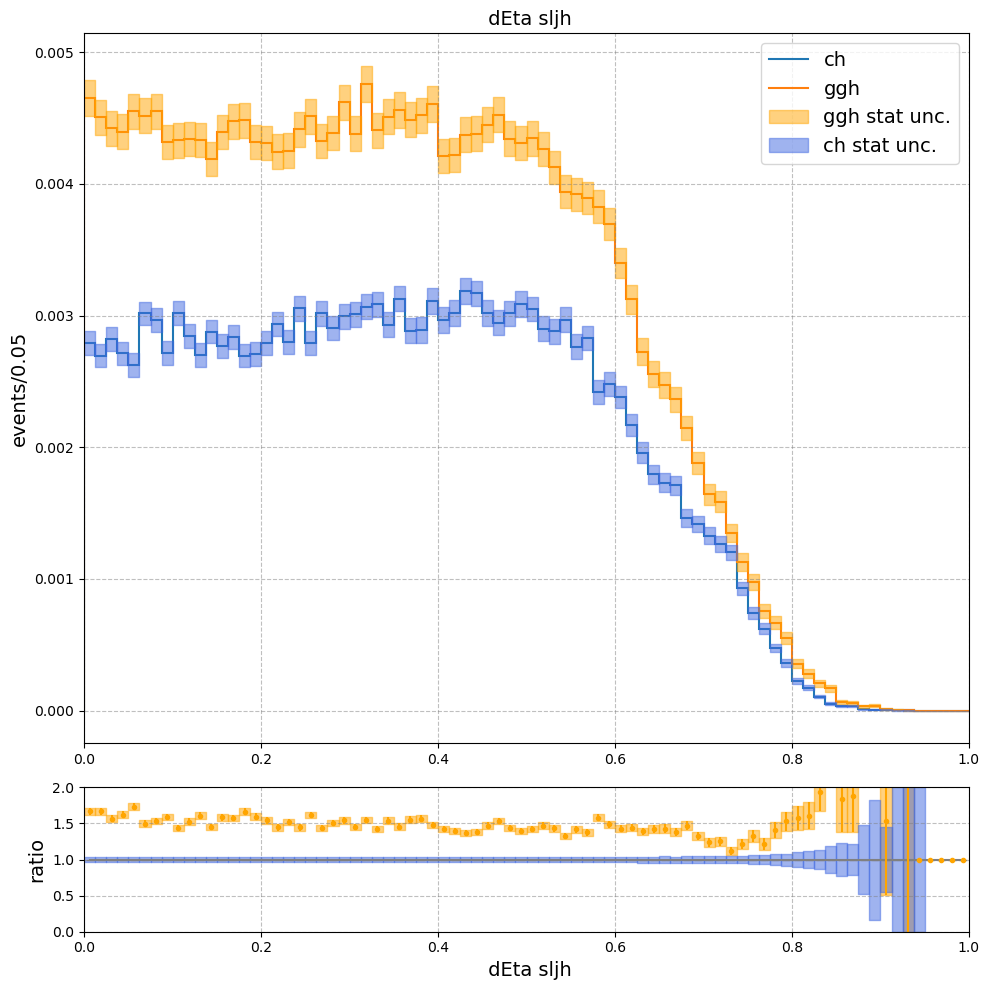

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "dEta_sljh"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 1
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_57918/1233181441.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/1233181441.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_57918/1233181441.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


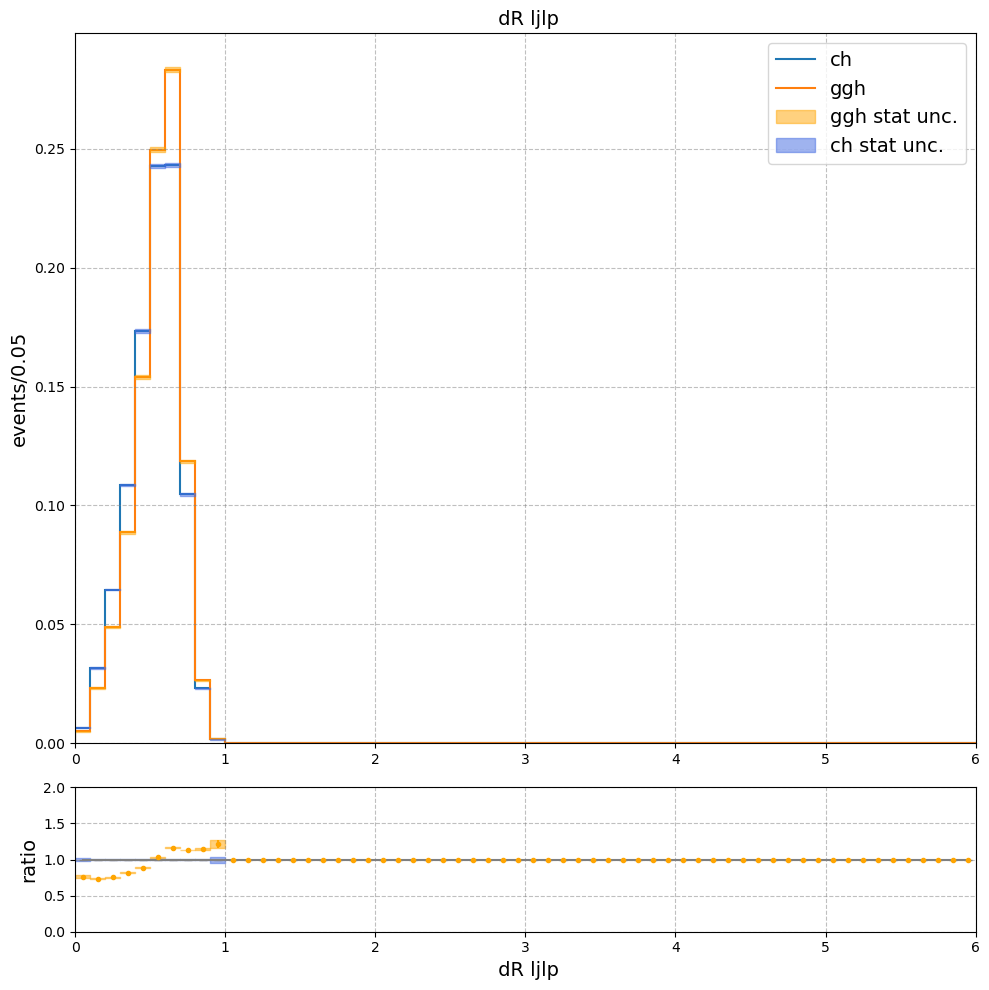

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "dR_ljlp"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 6
nbins = 60

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_57918/2914907583.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/2914907583.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_57918/2914907583.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


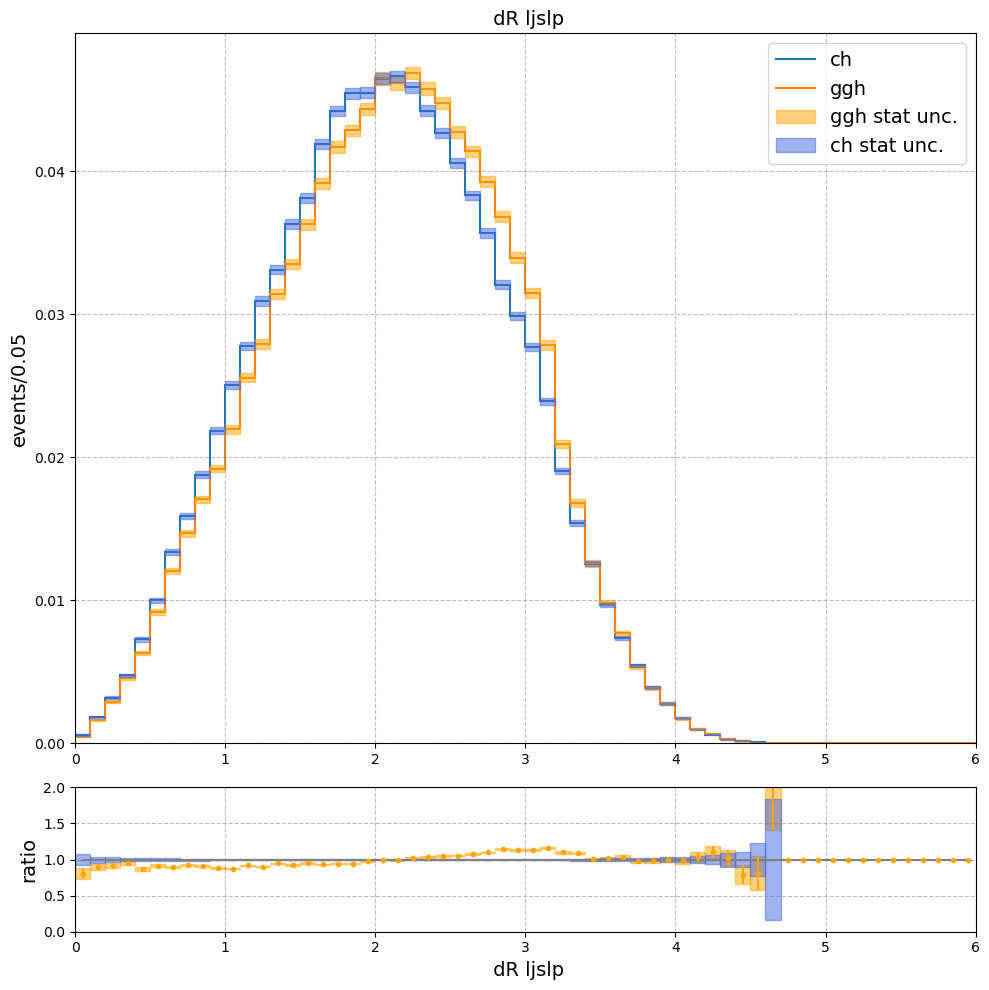

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "dR_ljslp"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 6
nbins = 60

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_57918/56361813.py:100: RuntimeWarning: divide by zero encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/56361813.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/56361813.py:104: RuntimeWarning: divide by zero encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_57918/56361813.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/work/bevila_t/MINICONDA3/envs/higgs-dna/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3683: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_57918/56361813.py:108: R

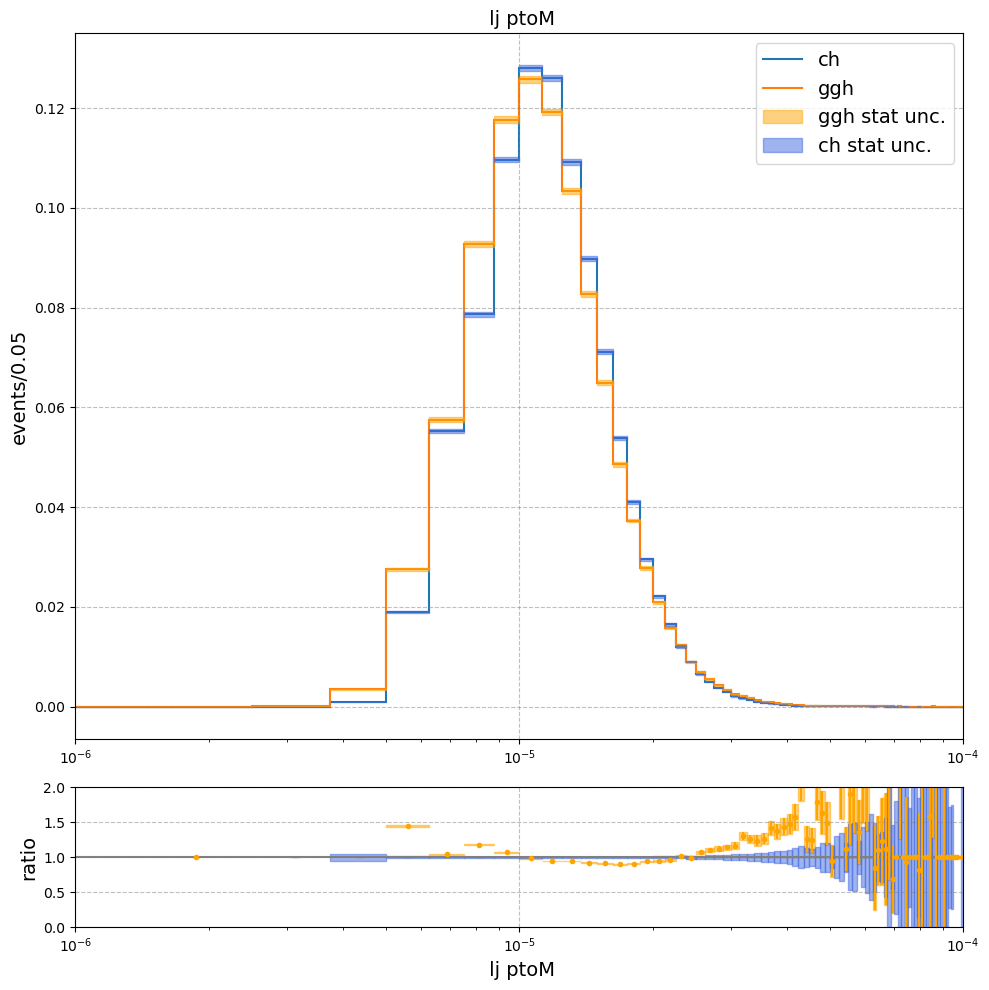

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "lj_ptoM"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 1e-4
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_+1e-6, max_])
ax0.set_xlim([min_+1e-6, max_])
ax1.set_xscale("log")
ax0.set_xscale("log")

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_57918/1062529612.py:100: RuntimeWarning: divide by zero encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/1062529612.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/1062529612.py:104: RuntimeWarning: divide by zero encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_57918/1062529612.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/work/bevila_t/MINICONDA3/envs/higgs-dna/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3683: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_57918/1062529612

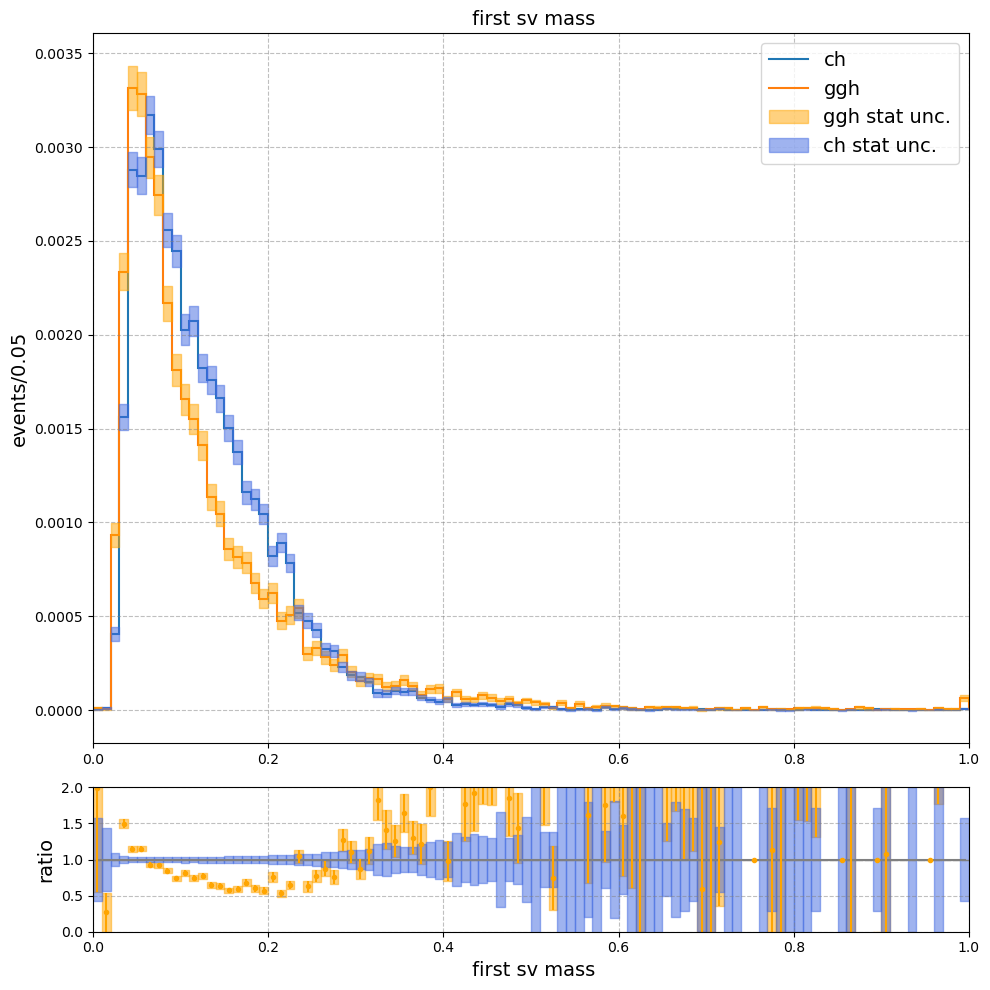

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_sv_mass"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 1
nbins = 100

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_57918/141604218.py:100: RuntimeWarning: divide by zero encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/141604218.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/141604218.py:104: RuntimeWarning: divide by zero encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_57918/141604218.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/work/bevila_t/MINICONDA3/envs/higgs-dna/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3683: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_57918/141604218.py:1

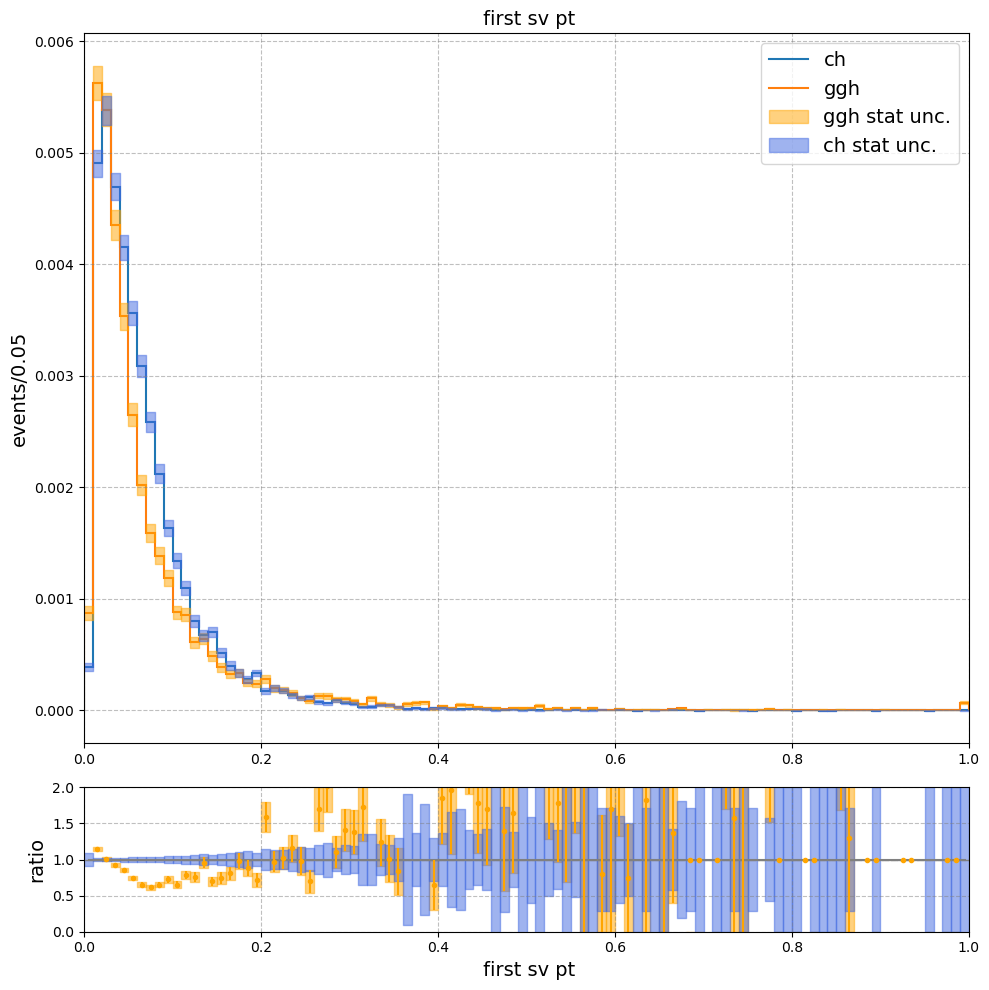

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_sv_pt"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 1
nbins = 100

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_57918/3831987454.py:100: RuntimeWarning: divide by zero encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/3831987454.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/3831987454.py:104: RuntimeWarning: divide by zero encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_57918/3831987454.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/work/bevila_t/MINICONDA3/envs/higgs-dna/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3683: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_57918/3831987454

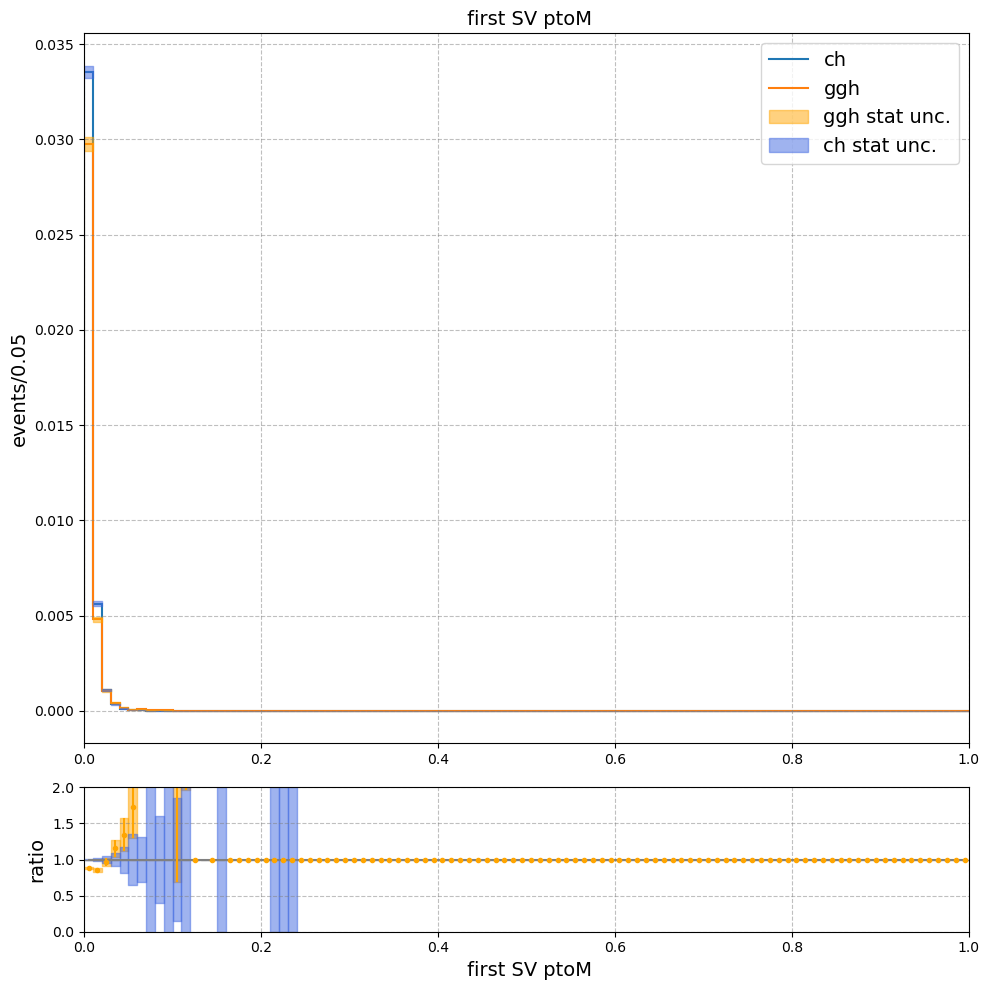

0.9999999999999998
1.0000000000000004


In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_SV_ptoM"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 1
nbins = 100

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))

ValueError: key "first_SV_ntracks" does not exist (not in record)

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/libawkward/util.cpp#L525)

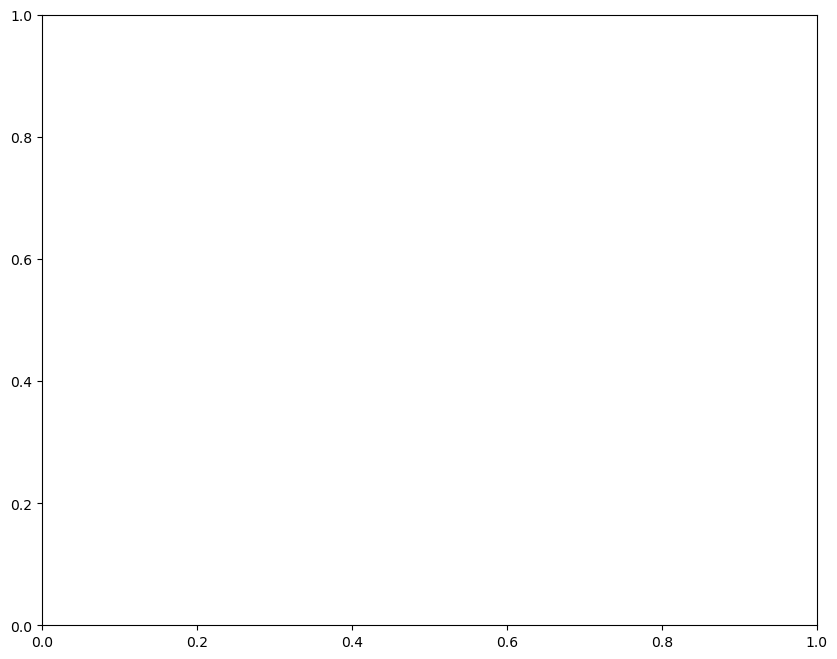

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_SV_ntracks"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 10
nbins = 10

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))

/tmp/ipykernel_57918/4222568690.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/4222568690.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_57918/4222568690.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


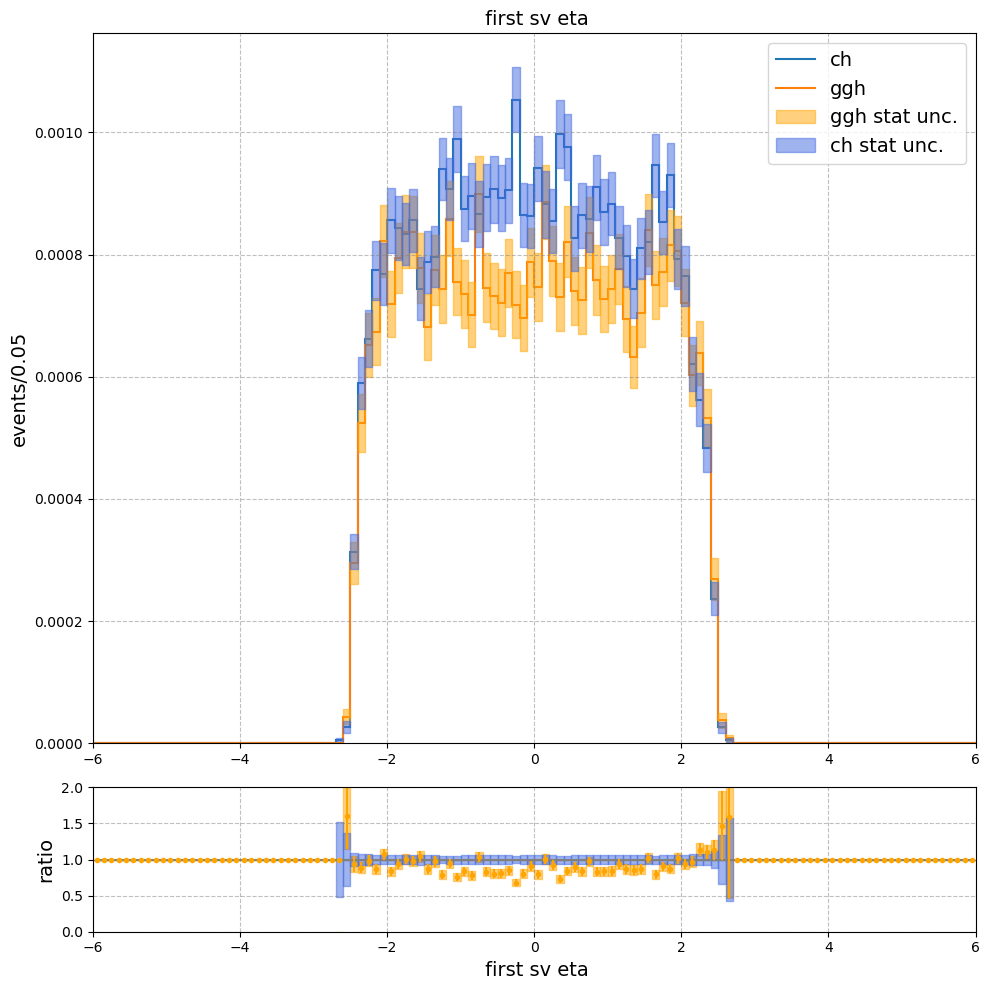

0.9999999999999998
1.0000000000000004


In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_sv_eta"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = -6
max_ = 6
nbins = 120

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))

/tmp/ipykernel_57918/2568088307.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_57918/2568088307.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_57918/2568088307.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


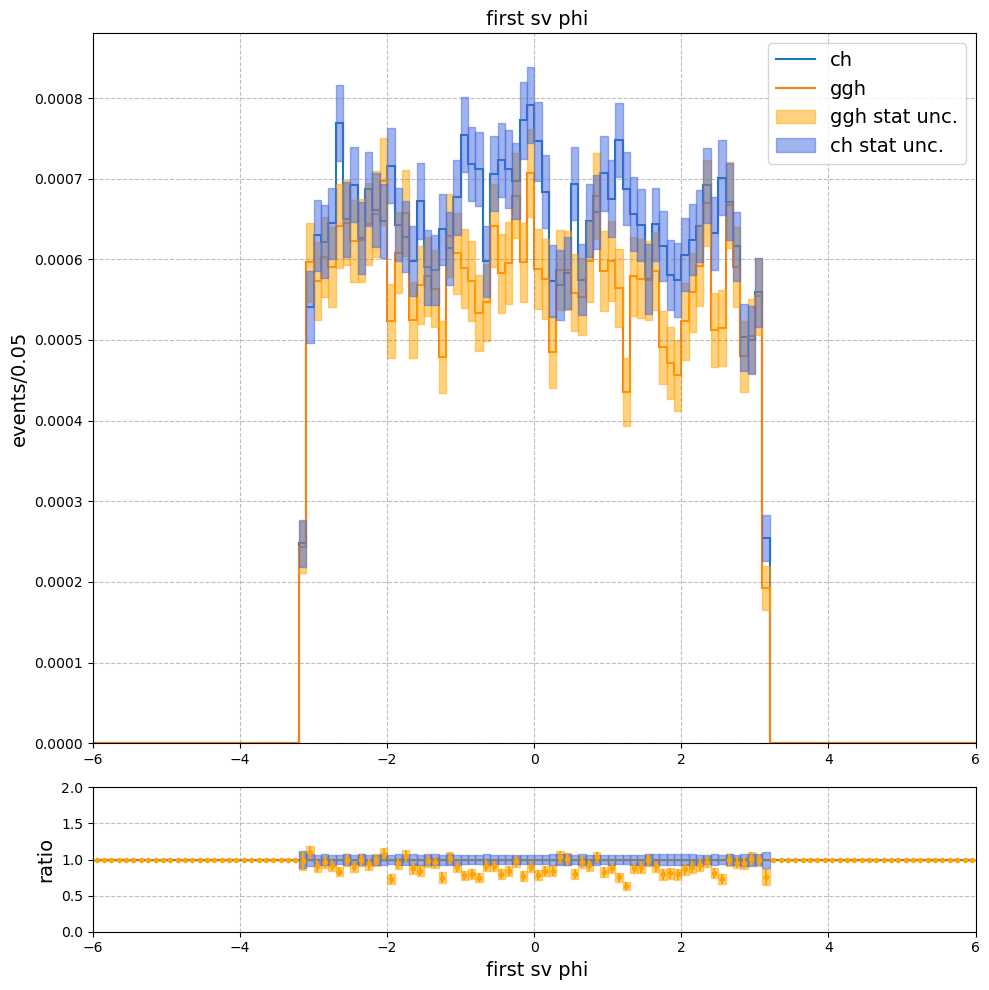

0.9999999999999998
1.0000000000000004


In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_sv_phi"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = -6
max_ = 6
nbins = 120

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))

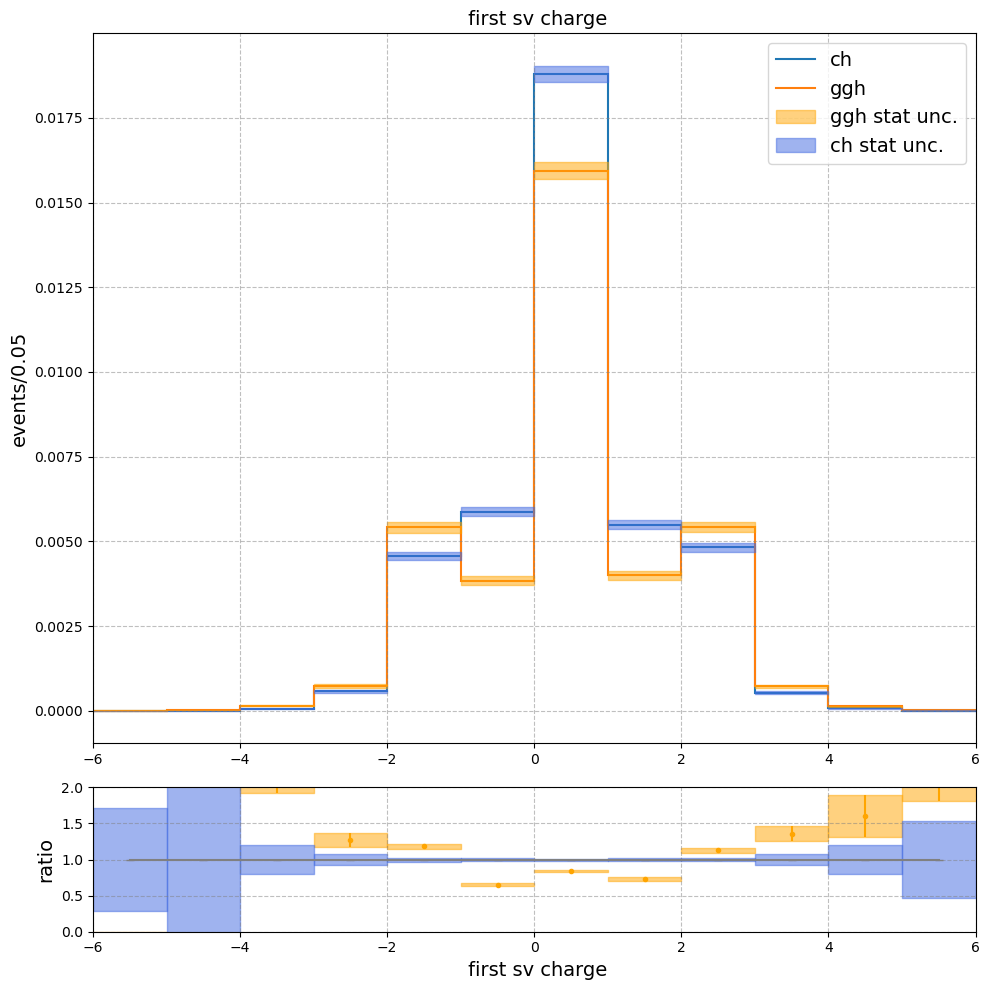

0.9999999999999998
1.0000000000000004


In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_sv_charge"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = -6
max_ = 6
nbins = 12

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))

/tmp/ipykernel_18909/3513458064.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/3513458064.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/3513458064.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


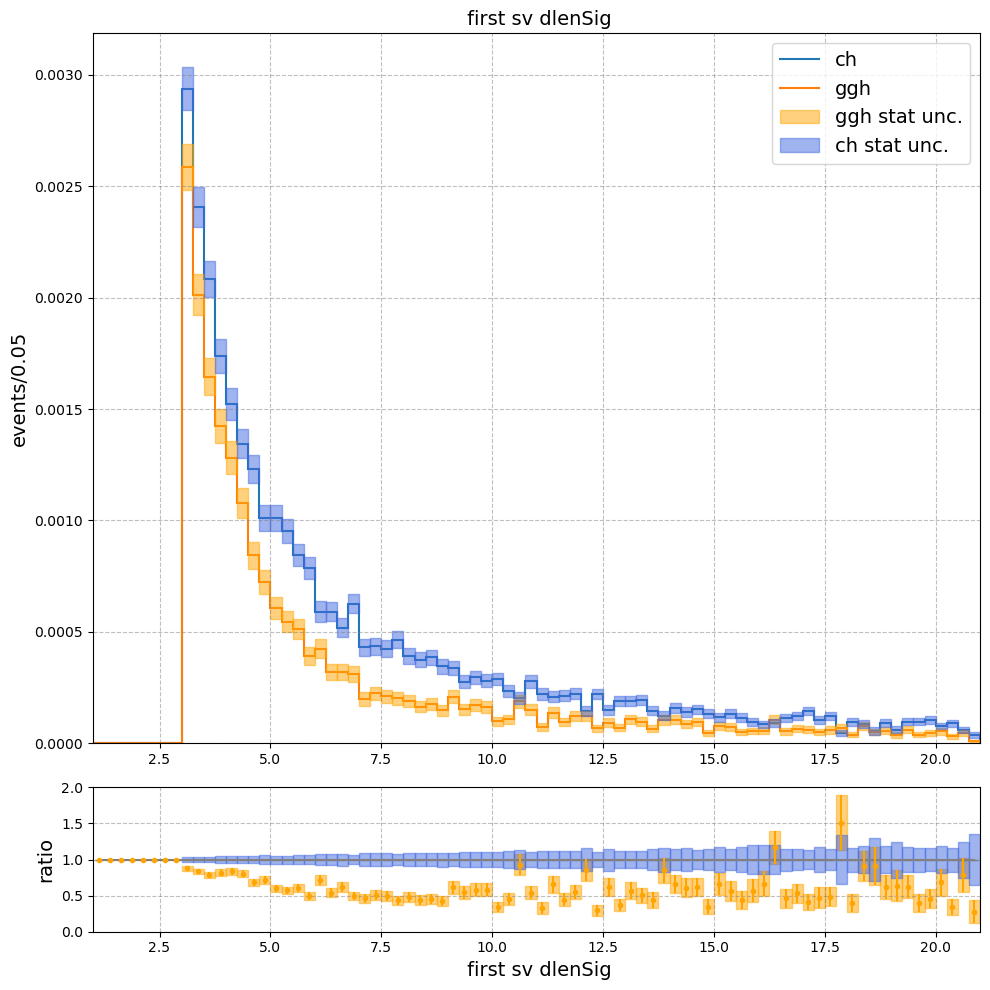

1.0
1.0000000000000004


In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_sv_dlenSig"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 1
max_ = 21
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))

/tmp/ipykernel_18909/3799984955.py:100: RuntimeWarning: divide by zero encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/3799984955.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/3799984955.py:104: RuntimeWarning: divide by zero encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/3799984955.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3680: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_18909/379998

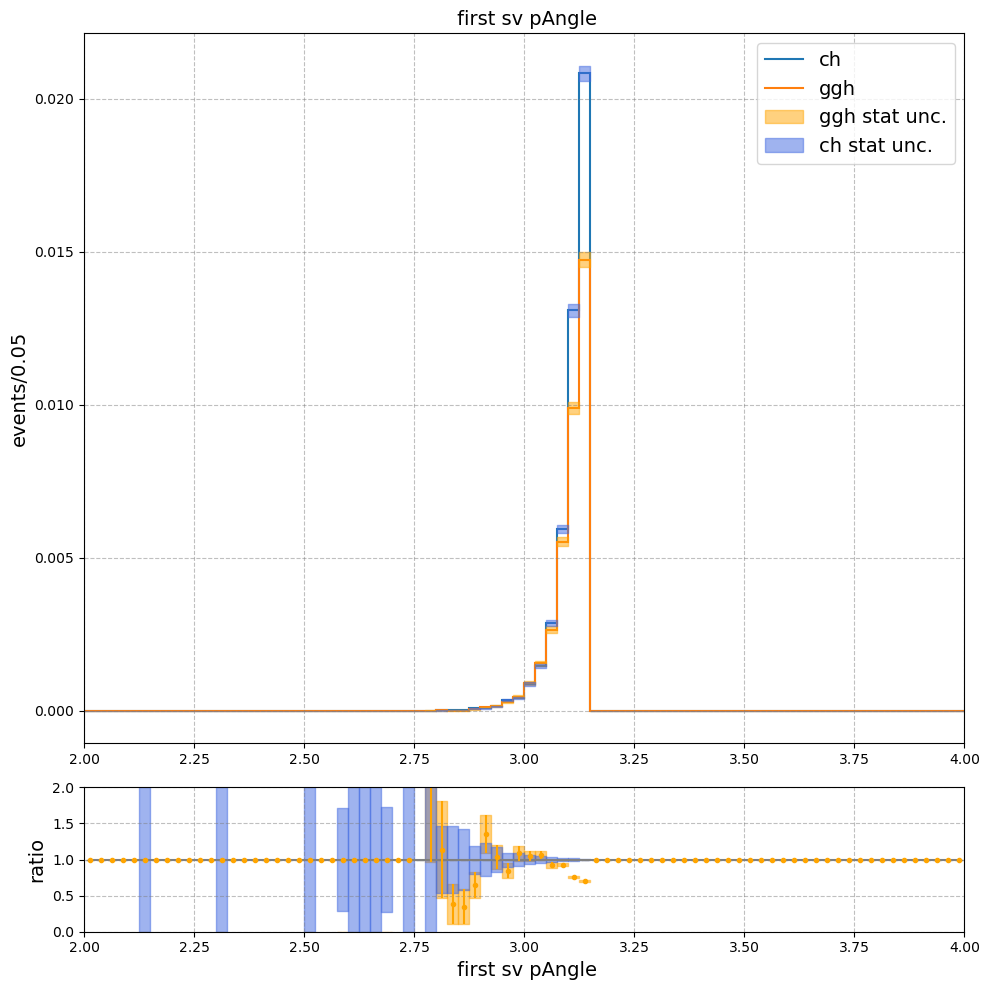

1.0
1.0000000000000004


In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_sv_pAngle"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 2
max_ = 4
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))

/tmp/ipykernel_18909/3151981319.py:100: RuntimeWarning: divide by zero encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/3151981319.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/3151981319.py:104: RuntimeWarning: divide by zero encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/3151981319.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3680: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_18909/315198

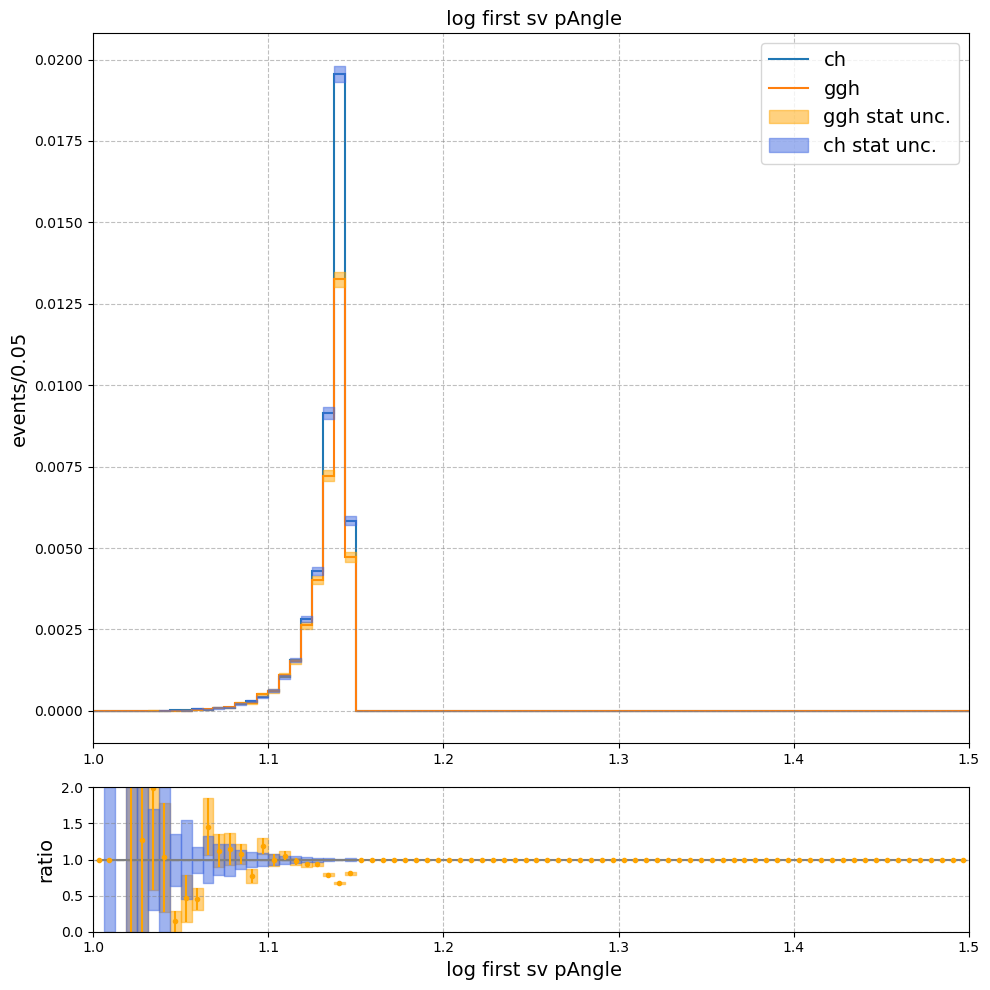

1.0
1.0000000000000004


In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "log_first_sv_pAngle"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 1
max_ = 1.5
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))

/tmp/ipykernel_18909/614630724.py:100: RuntimeWarning: divide by zero encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/614630724.py:104: RuntimeWarning: divide by zero encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3680: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_18909/614630724.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")
/tmp/ipykernel_18909/614630724.p

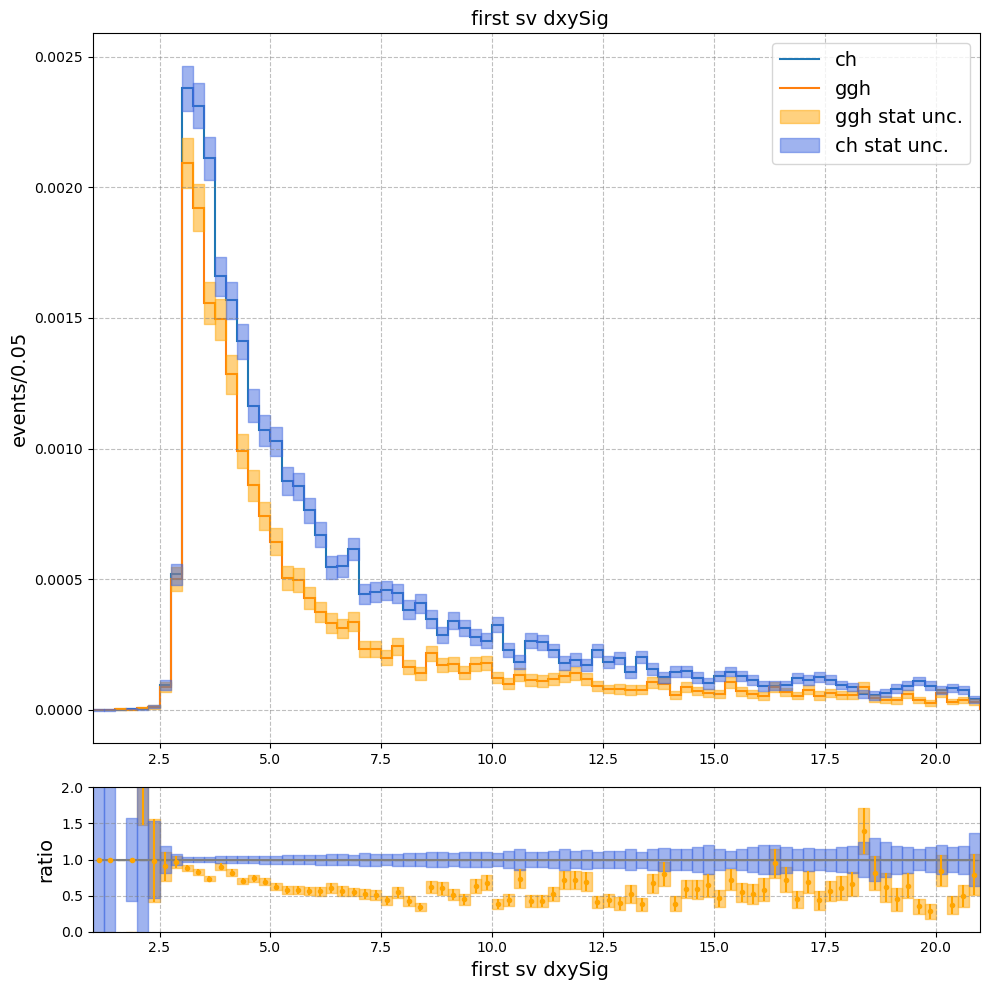

1.0
1.0000000000000004


In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_sv_dxySig"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 1
max_ = 21
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))